# Data Preprocessing


#### **Import Library yang diperlukan**

In [1]:
import pandas as pd
import psycopg2
from psycopg2 import sql
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

#### **Setup Database PostgreSQL dan MySQL (DATA IRIS)**

Proses pembuatan database PostgreSQL dan MySQL dilakukan melalui aiven.io, kemudian dikoneksikan ke DBeaver dan phpMyAdmin menggunakan kredensial dari Aiven. Setelah itu dibuat database baru, lalu data dari dataset IRIS diimpor dalam bentuk CSV. Dataset tersebut dipisahkan ke dalam dua tabel dengan atribut berbeda, masing-masing disimpan pada database yang berbeda, yaitu PostgreSQL dan MySQL.

#### Langkah-Langkah membuat Service Postgre dan MySQL dalam Aiven


1.   Akses situs aiven.io
dan lakukan login, atau daftar terlebih dahulu jika belum memiliki akun.

2. Buat Project baru sebelum menambahkan service.

3. Klik “Create Service”, lalu pilih PostgreSQL sebagai database.Lakukan hal yang sama untuk yang MySQL
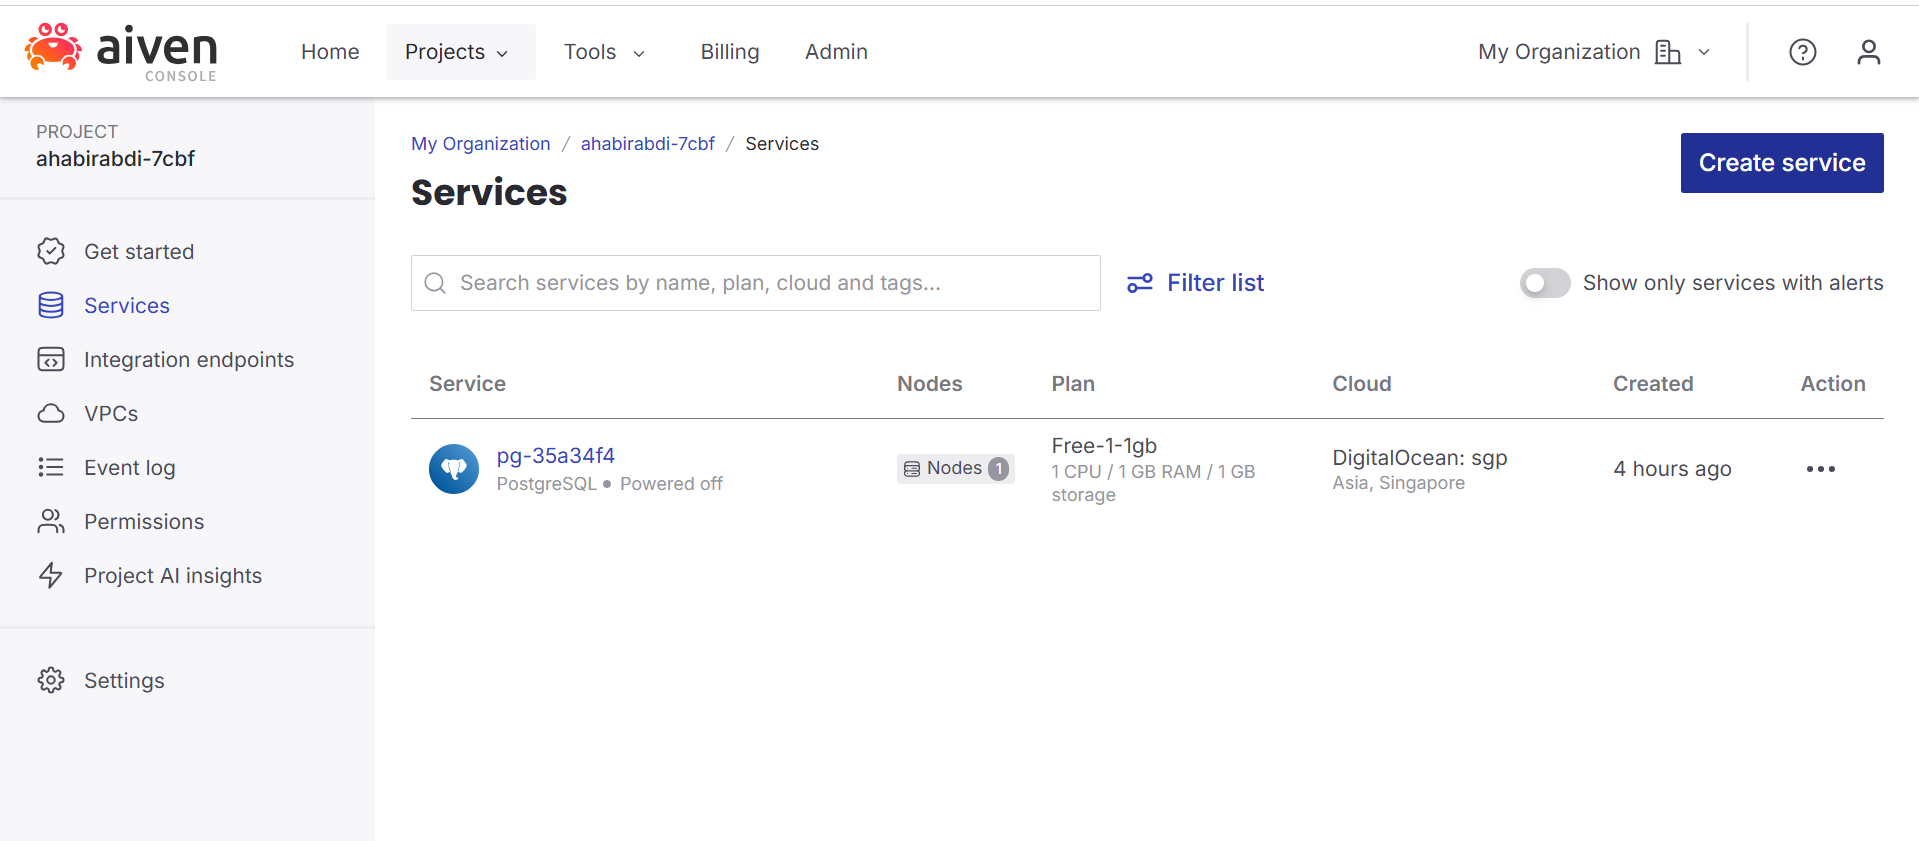

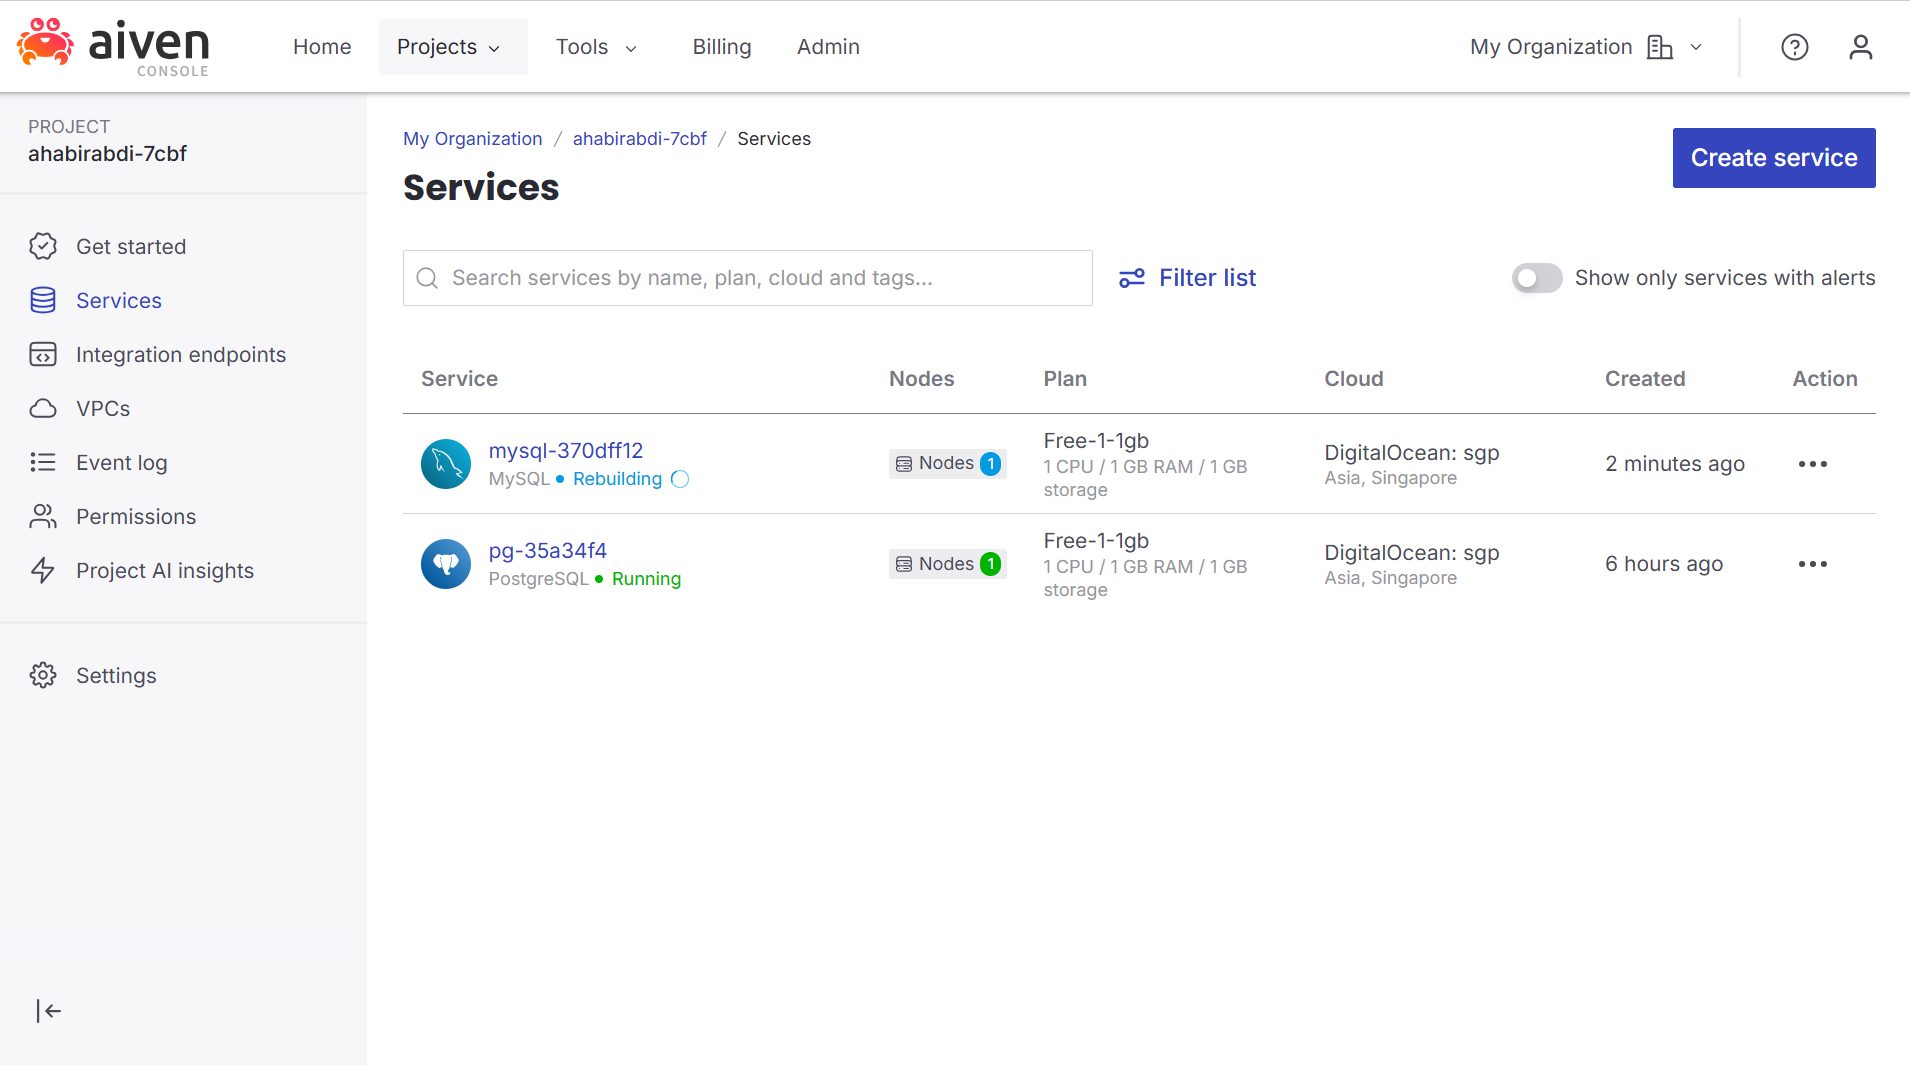

4. Setelah service dibuat, akan ditampilkan informasi mengenai detail service, metode koneksi, serta kredensial yang dapat digunakan.
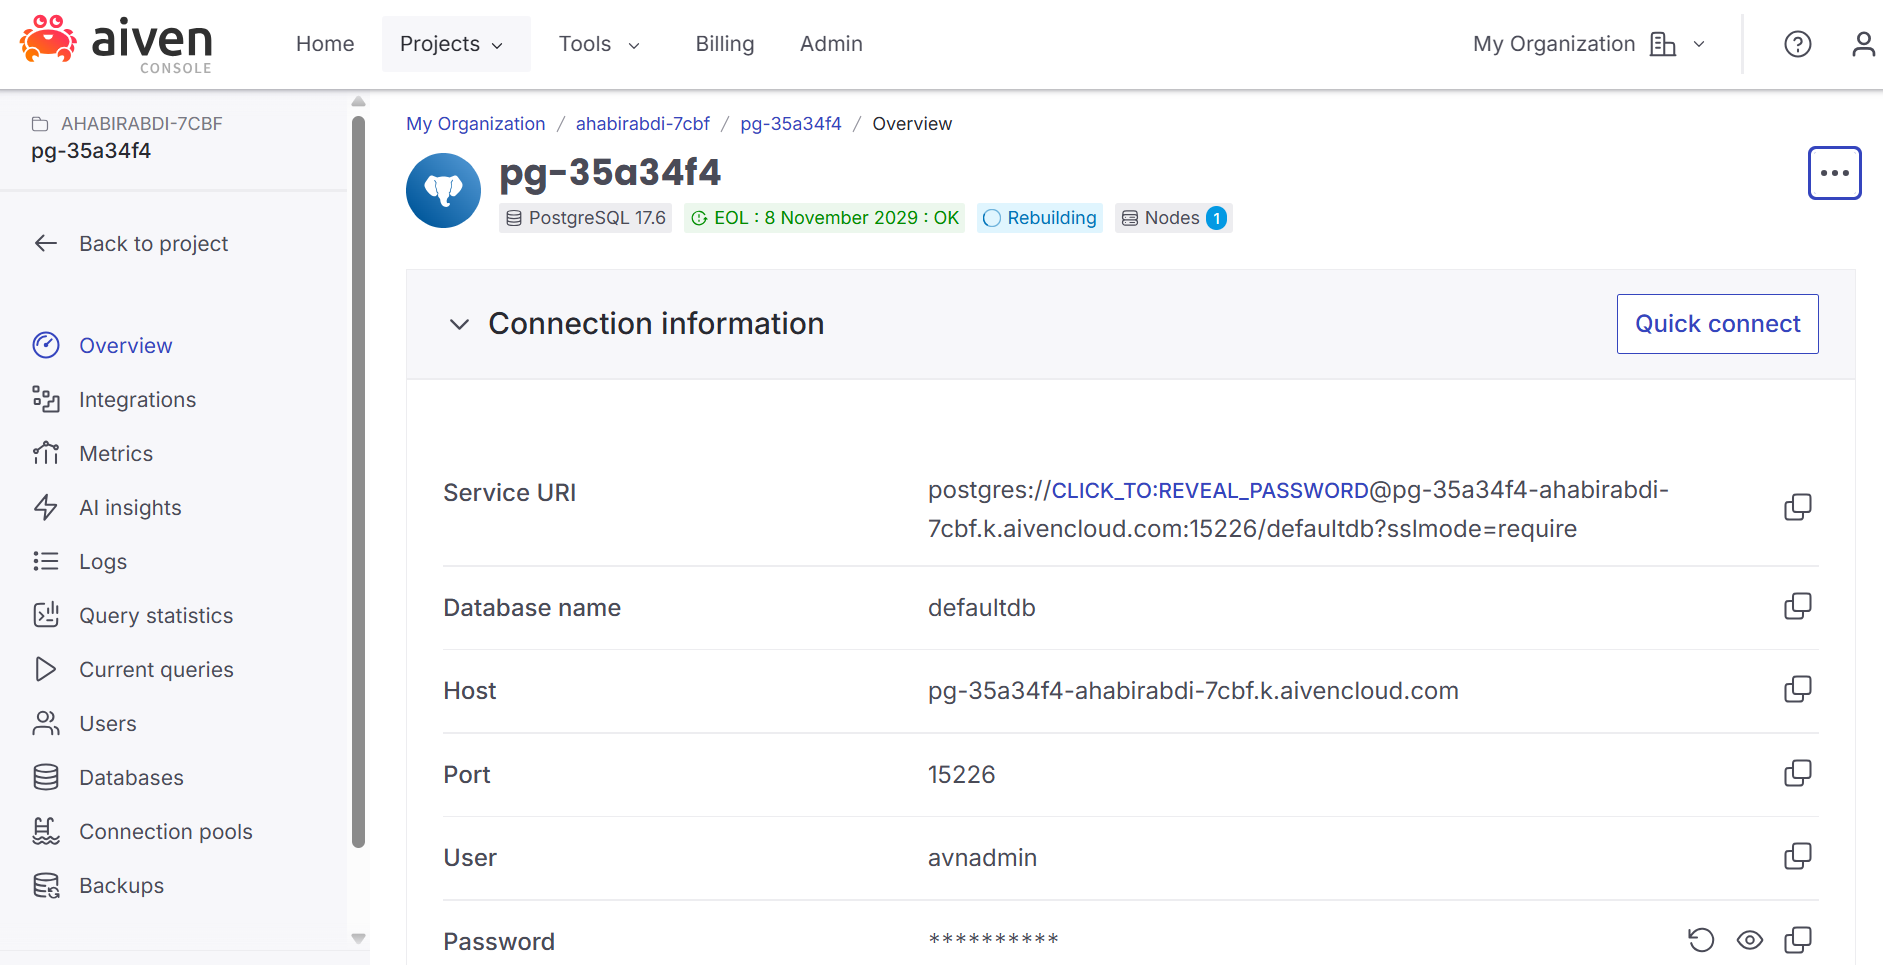





#### **Menarik Data dari Dua Sumber yang berbeda di Power BI (MySQL dan PostgreSQL)**

In [2]:
# 1. Impor semua library yang dibutuhkan di awal
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

# 2. Muat variabel dari file .env
load_dotenv()

# Ambil kredensial untuk PostgreSQL
user_postgres = os.getenv("USER_POSTGRES")
password_postgres = os.getenv("PASS_POSTGRES")
host_postgres = os.getenv("HOST_POSTGRES")
port_postgres = os.getenv("PORT_POSTGRES")
db_postgres = os.getenv("DB_POSTGRES")

# Ambil kredensial untuk MySQL
user_mysql = os.getenv("USER_MYSQL")
password_mysql = os.getenv("PASS_MYSQL")
host_mysql = os.getenv("HOST_MYSQL")
port_mysql = os.getenv("PORT_MYSQL")
db_mysql = os.getenv("DB_MYSQL")


# 3. Siapkan koneksi dan buat engine (cukup sekali)
# String koneksi untuk PostgreSQL
postgres_conn_str = f"postgresql+psycopg2://{user_postgres}:{password_postgres}@{host_postgres}:{port_postgres}/{db_postgres}"

# String koneksi untuk MySQL (menggunakan pymysql sebagai driver)
mysql_conn_str = f"mysql+pymysql://{user_mysql}:{password_mysql}@{host_mysql}:{port_mysql}/{db_mysql}"

# Buat engine untuk masing-masing database
postgres_engine = create_engine(postgres_conn_str)
mysql_engine = create_engine(mysql_conn_str)


# 4. Jalankan kueri dan ambil data
# Karena kuerinya sama, kita bisa buat satu variabel saja
query_iris = "SELECT * FROM iris;"

print("Mengambil data dari PostgreSQL...")
# Pandas bisa langsung menggunakan engine untuk membuka dan menutup koneksi
data_postgres = pd.read_sql(query_iris, postgres_engine)

print("Mengambil data dari MySQL...")
data_mysql = pd.read_sql(query_iris, mysql_engine)

# 5. Tampilkan hasil (opsional, untuk verifikasi)
print("\n--- Data dari PostgreSQL (5 baris pertama) ---")
print(data_postgres.head())

print("\n--- Data dari MySQL (5 baris pertama) ---")
print(data_mysql.head())

Mengambil data dari PostgreSQL...


OperationalError: (psycopg2.OperationalError) could not translate host name "pg-35a34f4-ahabirabdi-7cbf.k.aivencloud.com" to address: Name or service not known

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [7]:
# 6. Menggabungkan dua DataFrame berdasarkan kolom 'id'
print("\nMelakukan proses penggabungan (merge)...")

# Pastikan kedua DataFrame memiliki kolom 'id' sebelum menjalankan ini
if 'id' in data_postgres.columns and 'id' in data_mysql.columns:
    data_gabungan = pd.merge(
        left=data_postgres, 
        right=data_mysql, 
        how='inner', 
        on='id',
        suffixes=('_postgres', '_mysql')
    )

    # 7. Tampilkan hasil penggabungan
    print("\n--- Hasil Penggabungan (5 baris pertama) ---")
    print(data_gabungan.head())

    print("\nDimensi DataFrame hasil gabungan (baris, kolom):")
    print(data_gabungan.shape)

else:
    print("\n[PERINGATAN] Kolom 'id' tidak ditemukan di salah satu atau kedua DataFrame.")
    print("Penggabungan tidak dapat dilakukan. Periksa kembali nama kolom kunci Anda.")
    print("Kolom di data_postgres:", data_postgres.columns.tolist())
    print("Kolom di data_mysql:", data_mysql.columns.tolist())


Melakukan proses penggabungan (merge)...

--- Hasil Penggabungan (5 baris pertama) ---
   id  sepal length  sepal width  petal length  petal width
0   1           5.1          3.5           1.4          0.2
1   2           4.9          3.0           1.4          0.2
2   3           4.7          3.2           1.3          0.2
3   4           4.6          3.1           1.5          0.2
4   5           5.0          3.6           1.4          0.2

Dimensi DataFrame hasil gabungan (baris, kolom):
(150, 5)


Menggunakan Power BI :

1. masuk ke menu get data -> pilih python script

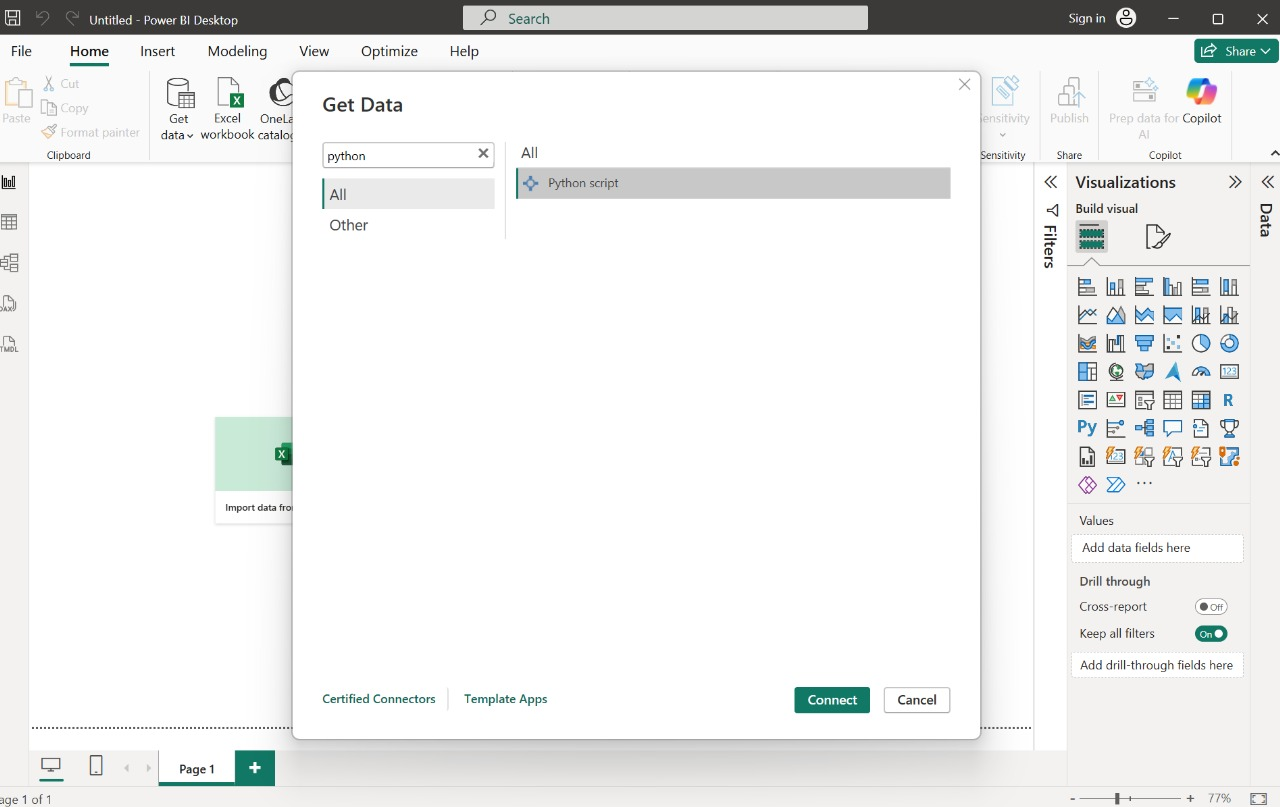

2. masukkan script pythonnya untuk menarik data dari MySql dan PostgreSQL

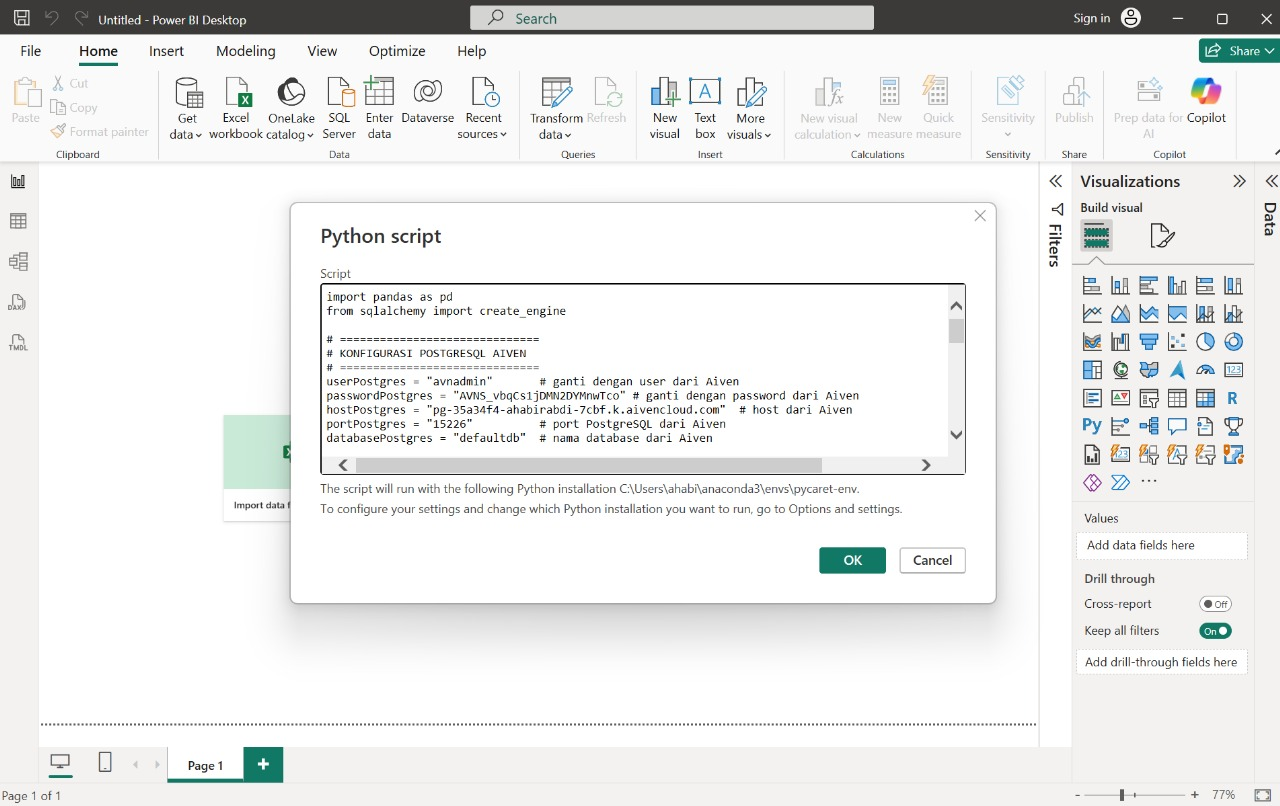

3. jika berhasil,bisa di load data nya,lalu masuk ke transform data untuk menggabungkan kedua data ini

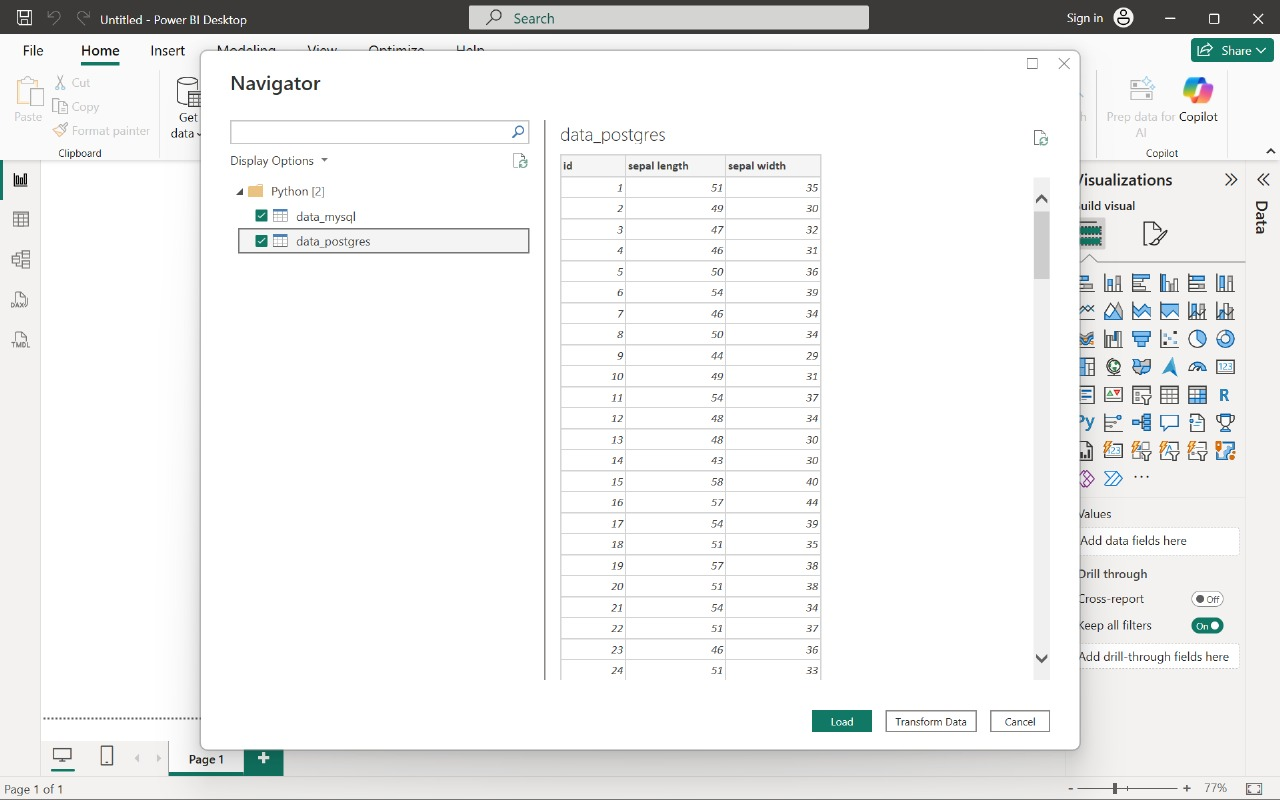

4. klik Merge Queries. Sebaiknya klik panah kecil di bawahnya dan pilih Merge Queries as New agar tabel asli Anda tetap utuh dan hasilnya dibuat di tabel baru.

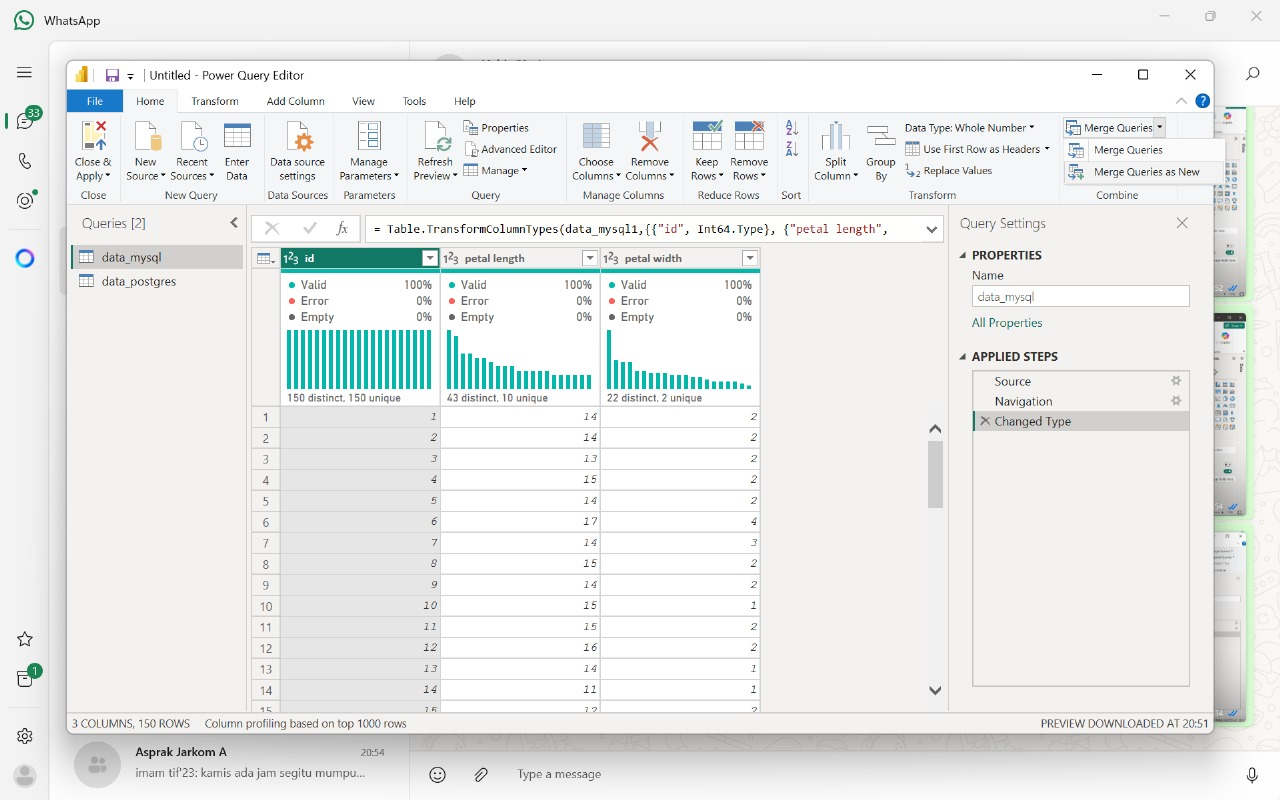

5. Lalu pilih untuk tabel yang pertama itu yang Postgre,tabel kedua MySQL.lalu klik untuk atribut ID untuk menandakan atribut itu untuk penghubungnya,dan pilih merge yang Inner (only matching rows).

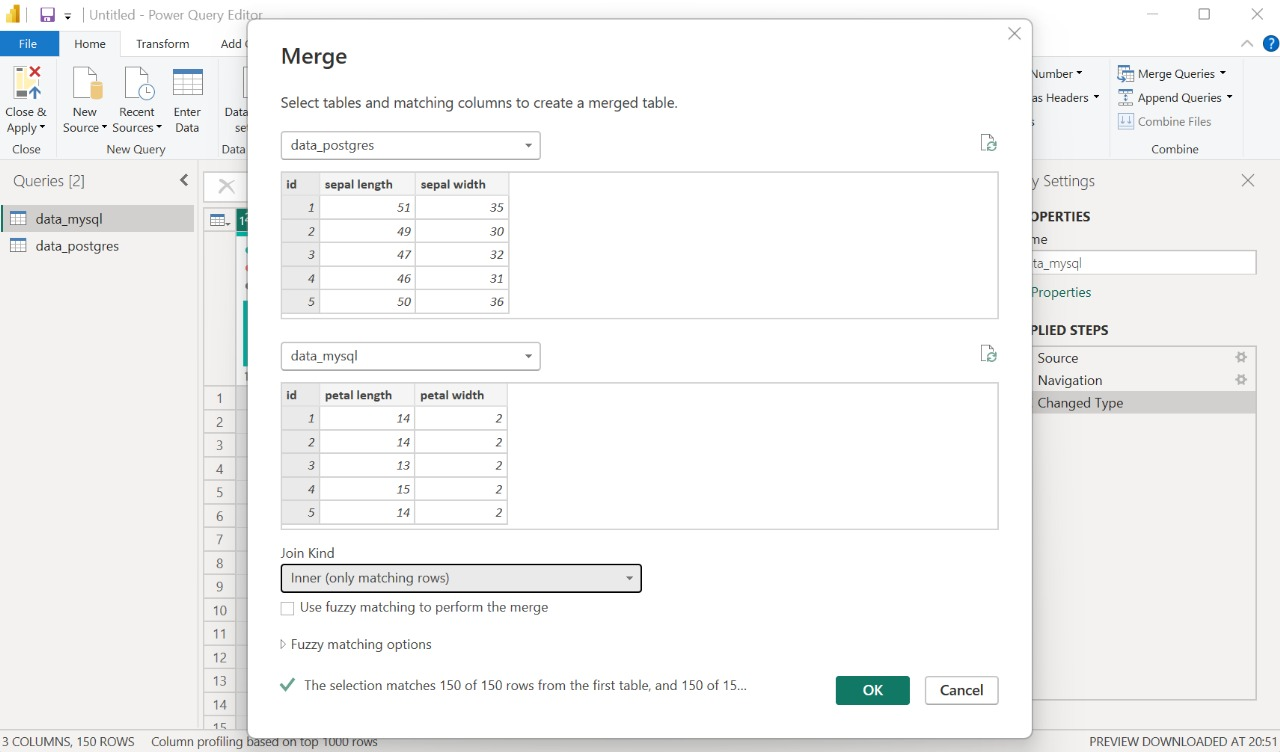

6. Tabel baru akan muncul bernama "Merge1",lalu klik ikon Expand di colom atribut data_mysql,sebuah menu akan muncul dan pilih untuk yang petal length dan petal width

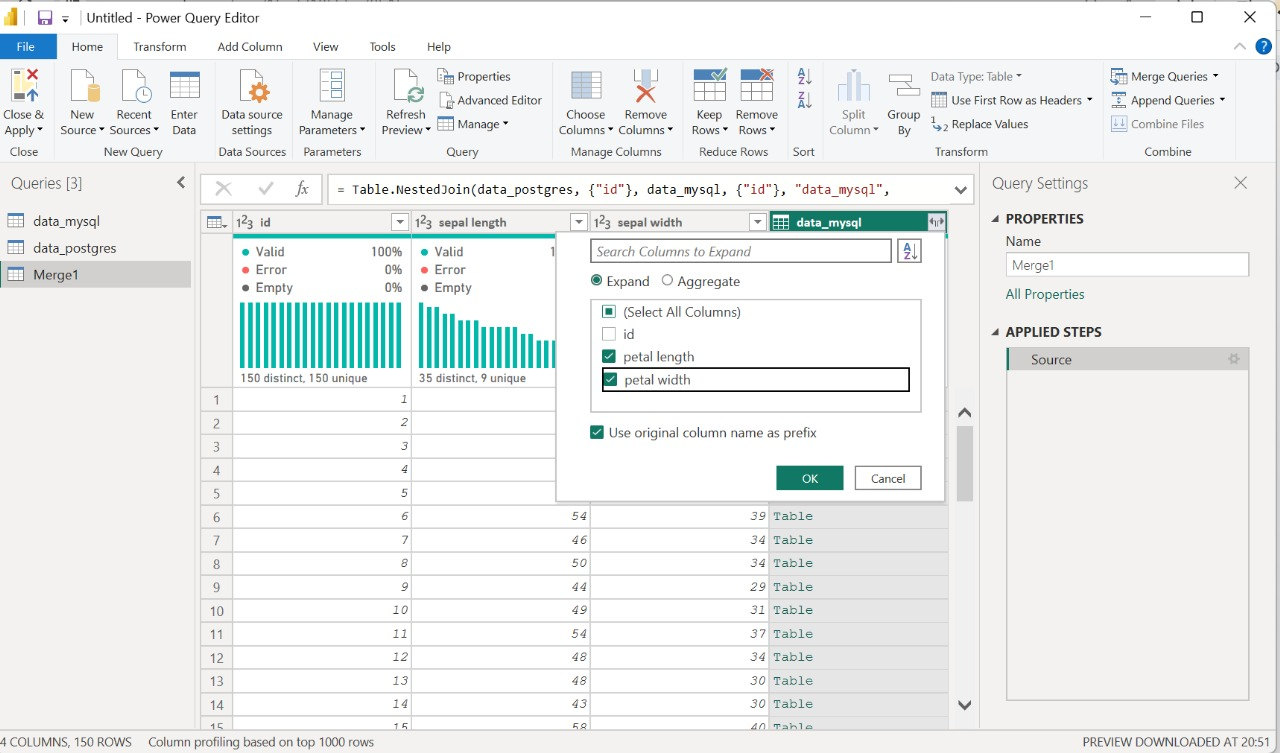

7. Ganti nama Tabelnya jadi "Tabel Iris".

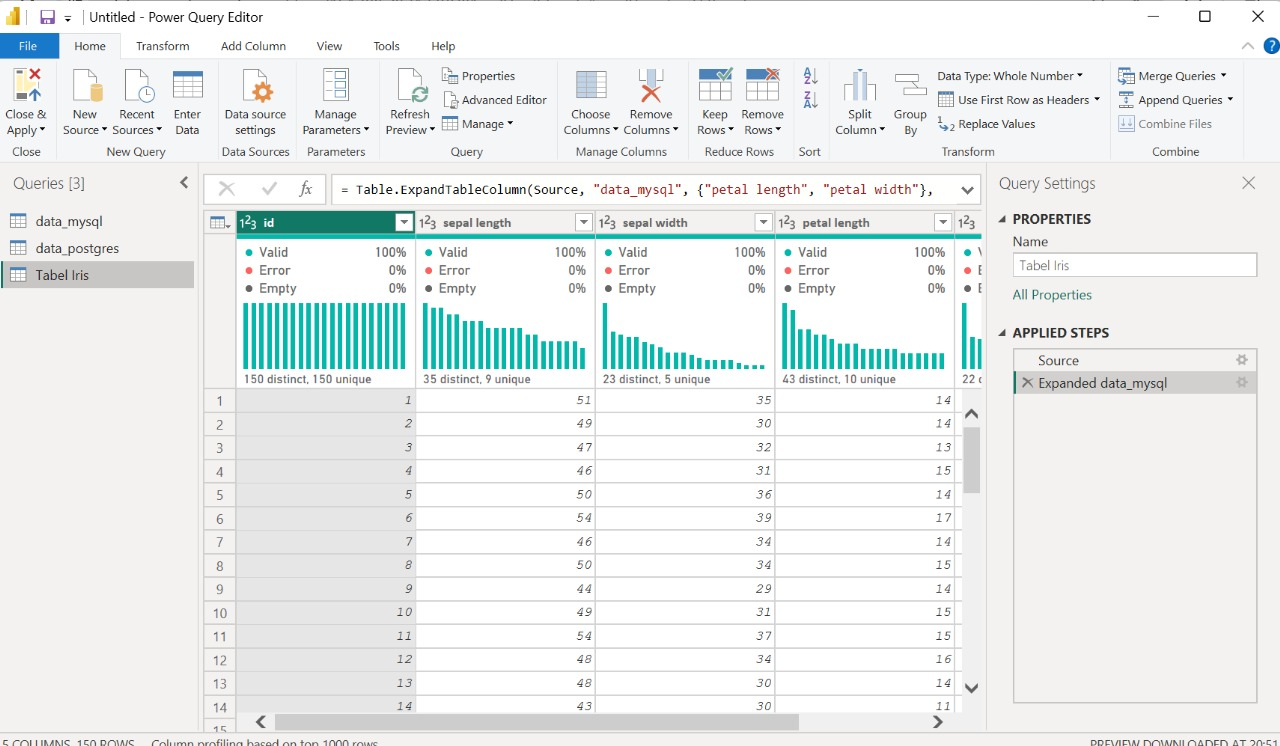

### **Outlier Analisis dengan KNN**



- Kode Analisis Outlier dengan (KNN) menggunakan pycaret

In [8]:
# Setup lingkungan PyCaret
from pycaret.anomaly import setup, create_model, assign_model

anomaly_setup = setup(data = data_gabungan, 
                      ignore_features = ['id'], 
                      session_id = 123, 
                      verbose = False) # verbose=False menyembunyikan detail setup

# Membuat model KNN
knn_model = create_model('knn')

# Menandai data untuk menemukan outlier
hasil_analisis_KNN = assign_model(knn_model)

# --------------------------------------------------------------------
# Bagian 2: PENGEMBANGAN - Menampilkan Outlier dan Rangkuman
# --------------------------------------------------------------------

# Filter DataFrame untuk mendapatkan baris yang merupakan outlier (Anomaly == 1)
outliers = hasil_analisis_KNN[hasil_analisis_KNN['Anomaly'] == 1]

print("--- Menampilkan Baris Data yang Terdeteksi Outlier ---")

# Cek apakah ada outlier yang ditemukan atau tidak
if outliers.empty:
  print("✅ Selamat! Tidak ada outlier yang terdeteksi oleh model.")
else:
  print(f"Ditemukan {len(outliers)} baris data yang merupakan outlier:")
  print(outliers)

# Membuat Rangkuman Hasil Analisis
print("\n--- Rangkuman Hasil Analisis Outlier ---")

# Menghitung statistik
total_data = len(hasil_analisis_KNN)
jumlah_outlier = len(outliers)
persentase_outlier = (jumlah_outlier / total_data) * 100

# Menampilkan rangkuman
print(f"📊 Dari total {total_data} data, model KNN mengidentifikasi {jumlah_outlier} data sebagai outlier.")
print(f"📈 Persentase data outlier dalam dataset ini adalah {persentase_outlier:.2f}%.")
print(f"💡 Kolom 'Anomaly_Score' menunjukkan seberapa kuat suatu titik data dianggap sebagai anomali. Semakin tinggi skornya, semakin besar kemungkinan data tersebut adalah outlier.")

--- Menampilkan Baris Data yang Terdeteksi Outlier ---
Ditemukan 8 baris data yang merupakan outlier:
     sepal length  sepal width  petal length  petal width  Anomaly  \
41            4.5          2.3           1.3          0.3        1   
57            4.9          2.4           3.3          1.0        1   
98            5.1          2.5           3.0          1.1        1   
106           4.9          2.5           4.5          1.7        1   
109           7.2          3.6           6.1          2.5        1   
117           7.7          3.8           6.7          2.2        1   
118           7.7          2.6           6.9          2.3        1   
131           7.9          3.8           6.4          2.0        1   

     Anomaly_Score  
41        0.793726  
57        0.787401  
98        0.818535  
106       0.883176  
109       0.806226  
117       1.019804  
118       0.964365  
131       1.024695  

--- Rangkuman Hasil Analisis Outlier ---
📊 Dari total 150 data, model KNN men

- Menghapus nilai outlier

In [10]:
print("--- Proses Menghapus Outlier ---")

# 1. Buat DataFrame baru hanya dengan data yang bukan outlier (Anomaly == 0)
#    Menggunakan .copy() adalah praktik yang baik untuk menghindari SettingWithCopyWarning
data_bersih = hasil_analisis_KNN[hasil_analisis_KNN['Anomaly'] == 0].copy()

# 2. Hapus kolom 'Anomaly' dan 'Anomaly_Score' yang sudah tidak diperlukan
data_bersih.drop(columns=['Anomaly', 'Anomaly_Score'], inplace=True)

print("✅ Proses penghapusan outlier selesai.")

# --- Verifikasi Hasil ---
print("\n--- Verifikasi Hasil Penghapusan ---")

jumlah_data_awal = len(hasil_analisis_KNN)
jumlah_outlier = len(outliers)
jumlah_data_bersih = len(data_bersih)

print(f"Jumlah data awal      : {jumlah_data_awal} baris")
print(f"Jumlah outlier dihapus : {jumlah_outlier} baris")
print(f"Jumlah data bersih sisa: {jumlah_data_bersih} baris")

print("\nLima baris pertama dari data yang sudah bersih dari outlier:")
print(data_bersih.head())

# Simpan hasil data bersih ke CSV
data_bersih.to_csv("data_bersih_KNN.csv", index=False, encoding="utf-8")

print("\n✅ File data_bersih.csv berhasil dibuat.")


--- Proses Menghapus Outlier ---
✅ Proses penghapusan outlier selesai.

--- Verifikasi Hasil Penghapusan ---
Jumlah data awal      : 150 baris
Jumlah outlier dihapus : 8 baris
Jumlah data bersih sisa: 142 baris

Lima baris pertama dari data yang sudah bersih dari outlier:
   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

✅ File data_bersih.csv berhasil dibuat.


#### **- Menggunakan Power BI untuk deteksi Outlier KNN**

- Masukkan script python dibawah ini untuk Analisis Outlier dengan Pycaret (KNN)

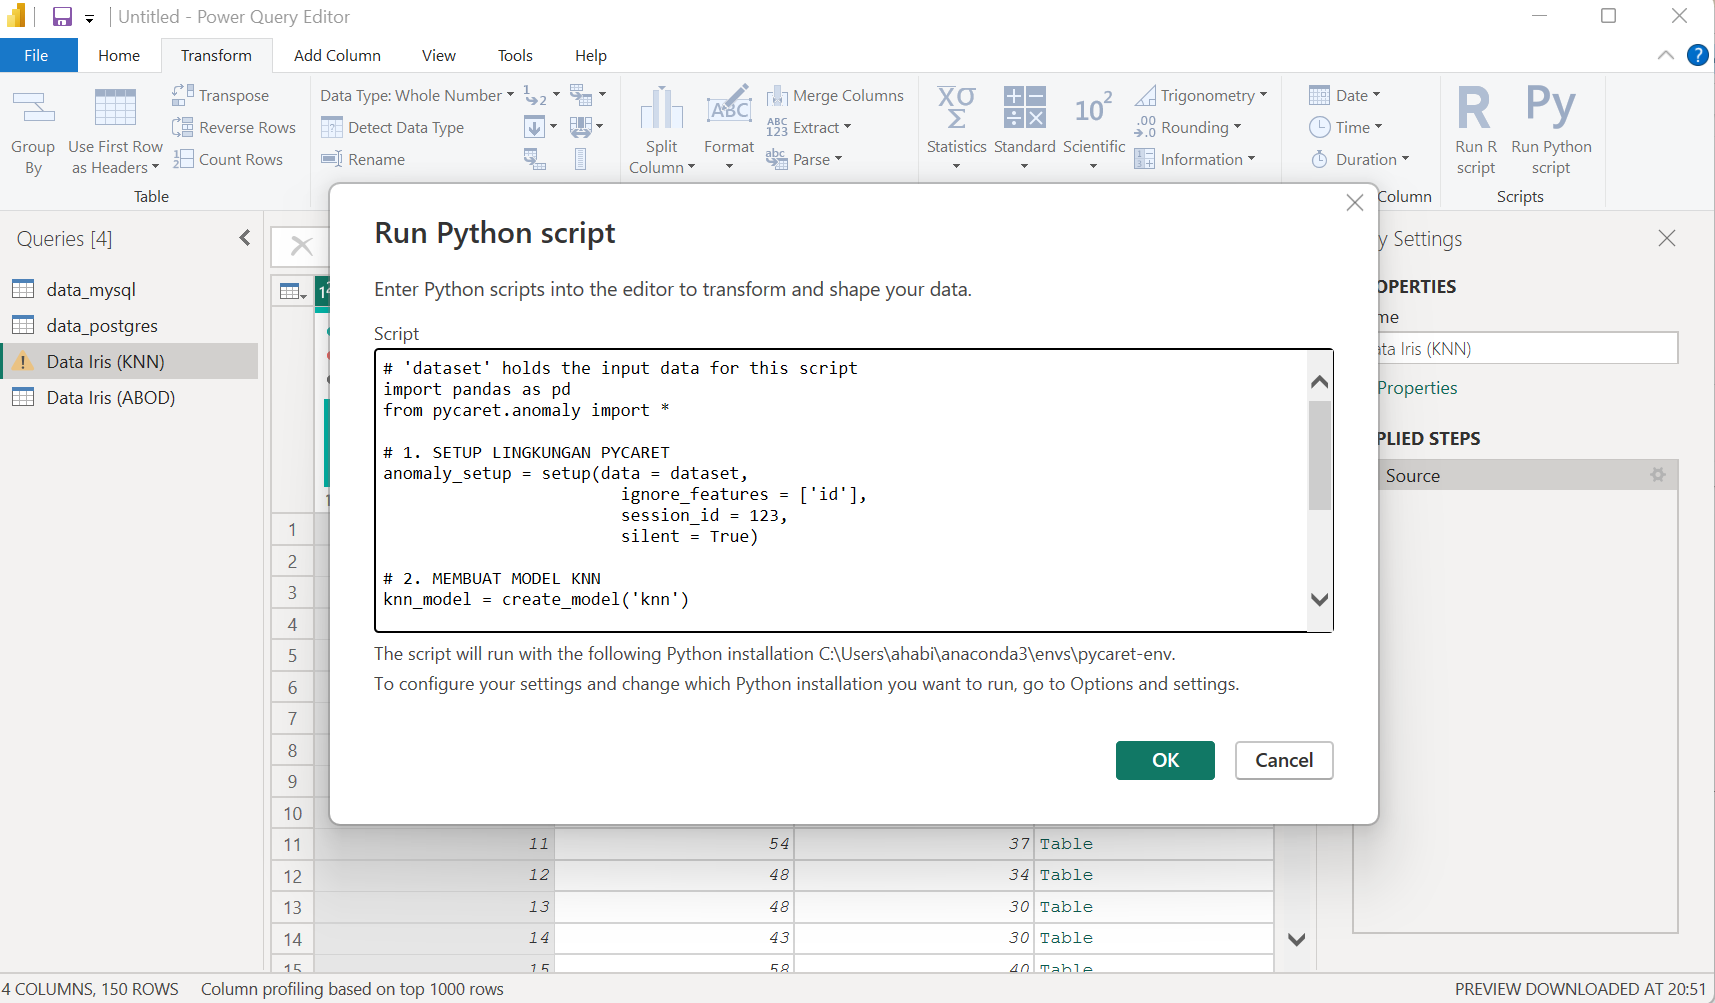

Setelah script berhasil berjalan, Power Query akan menampilkan hasilnya sebagai sebuah objek. Klik pada kata "Table",Hasilnya adalah tabel asli Anda yang kini memiliki dua kolom baru yaitu:
1. Anomaly: Berisi nilai 1 (jika outlier) atau 0 (jika bukan outlier).
2. Anomaly_Score: Skor numerik yang menunjukkan seberapa besar kemungkinan sebuah data adalah outlier.

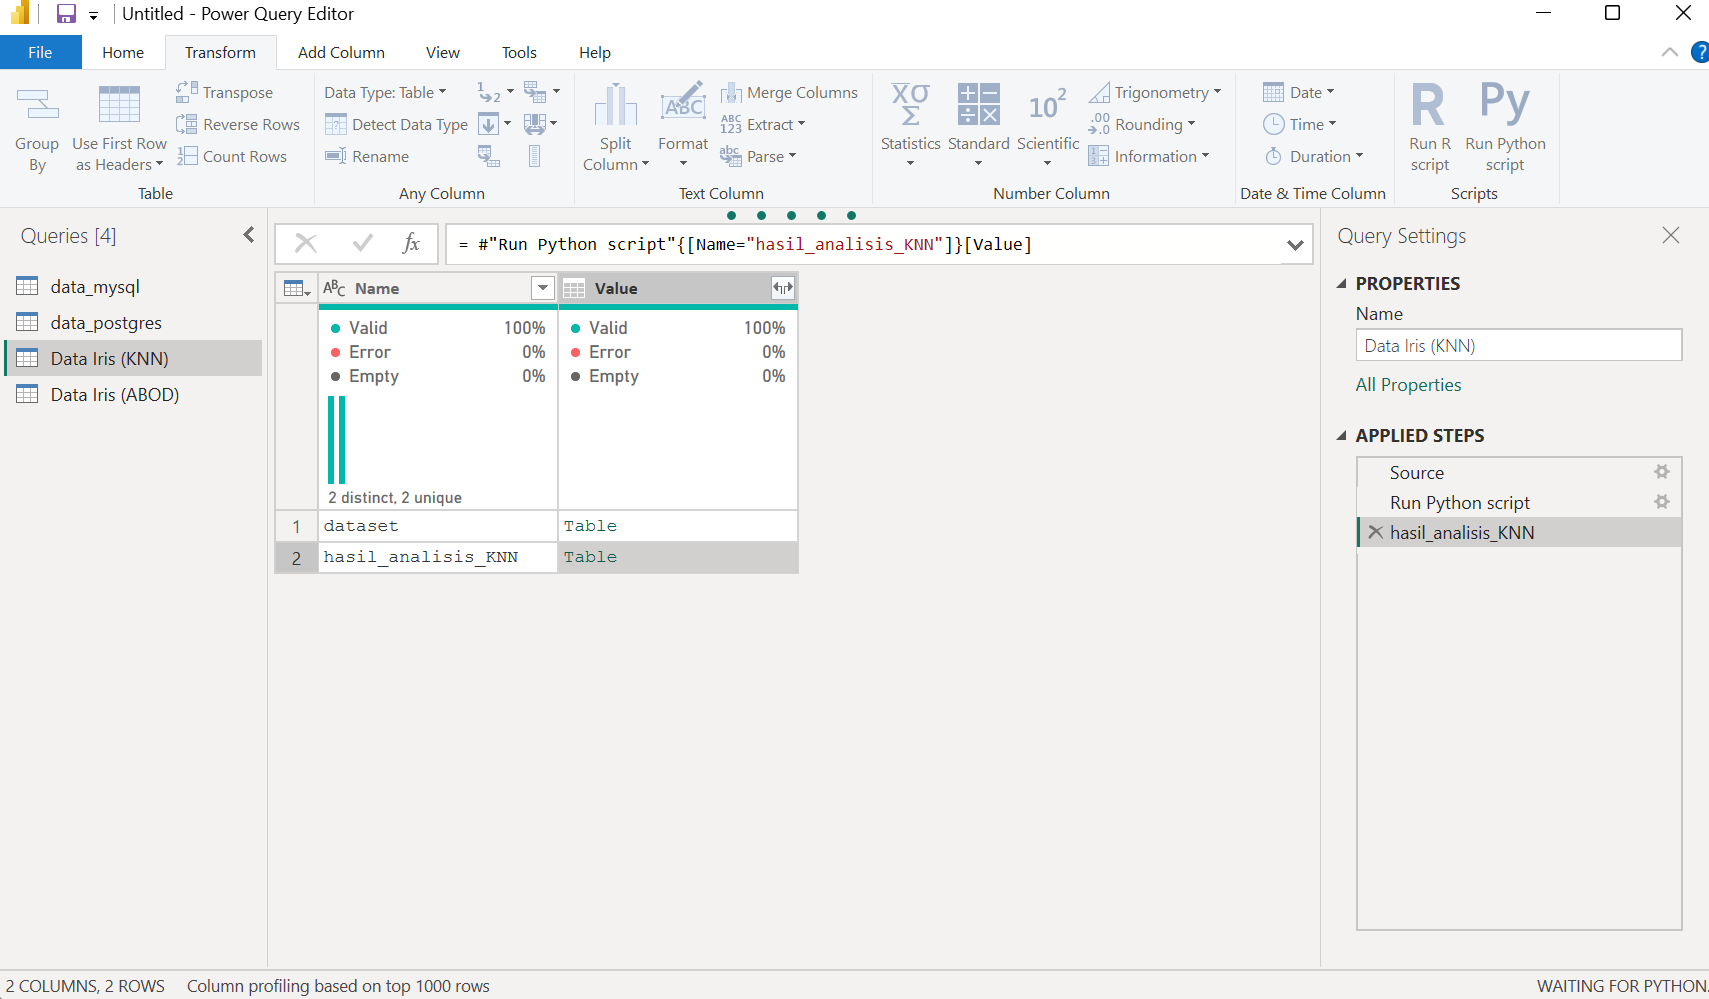

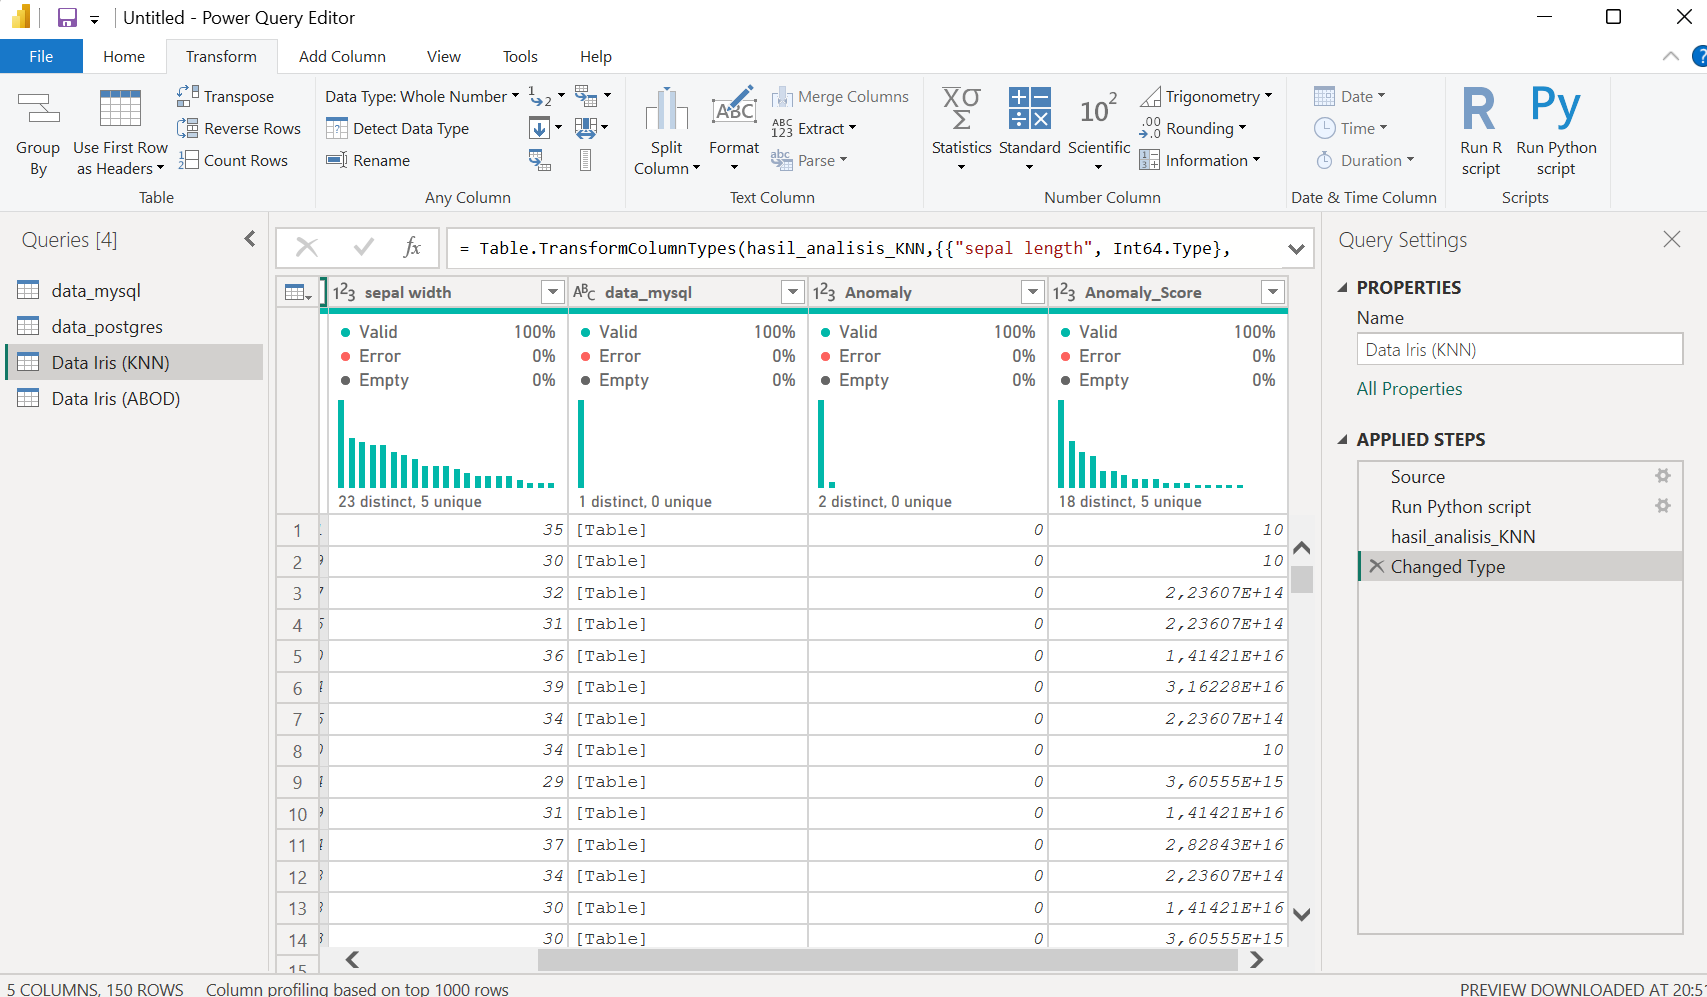

setelah itu hapus nilai outlier dengan cara Di Power Query Editor, filter kolom Anomaly dengan menghapus centang nilai 1 sehingga hanya menampilkan baris bernilai 0 (inlier), lalu klik OK untuk menerapkan perubahan.Setelah proses ini data menjadi lebih bersih dan bisa kita lanjutkan lagi untuk proses selanjutnya yaitu clustering.

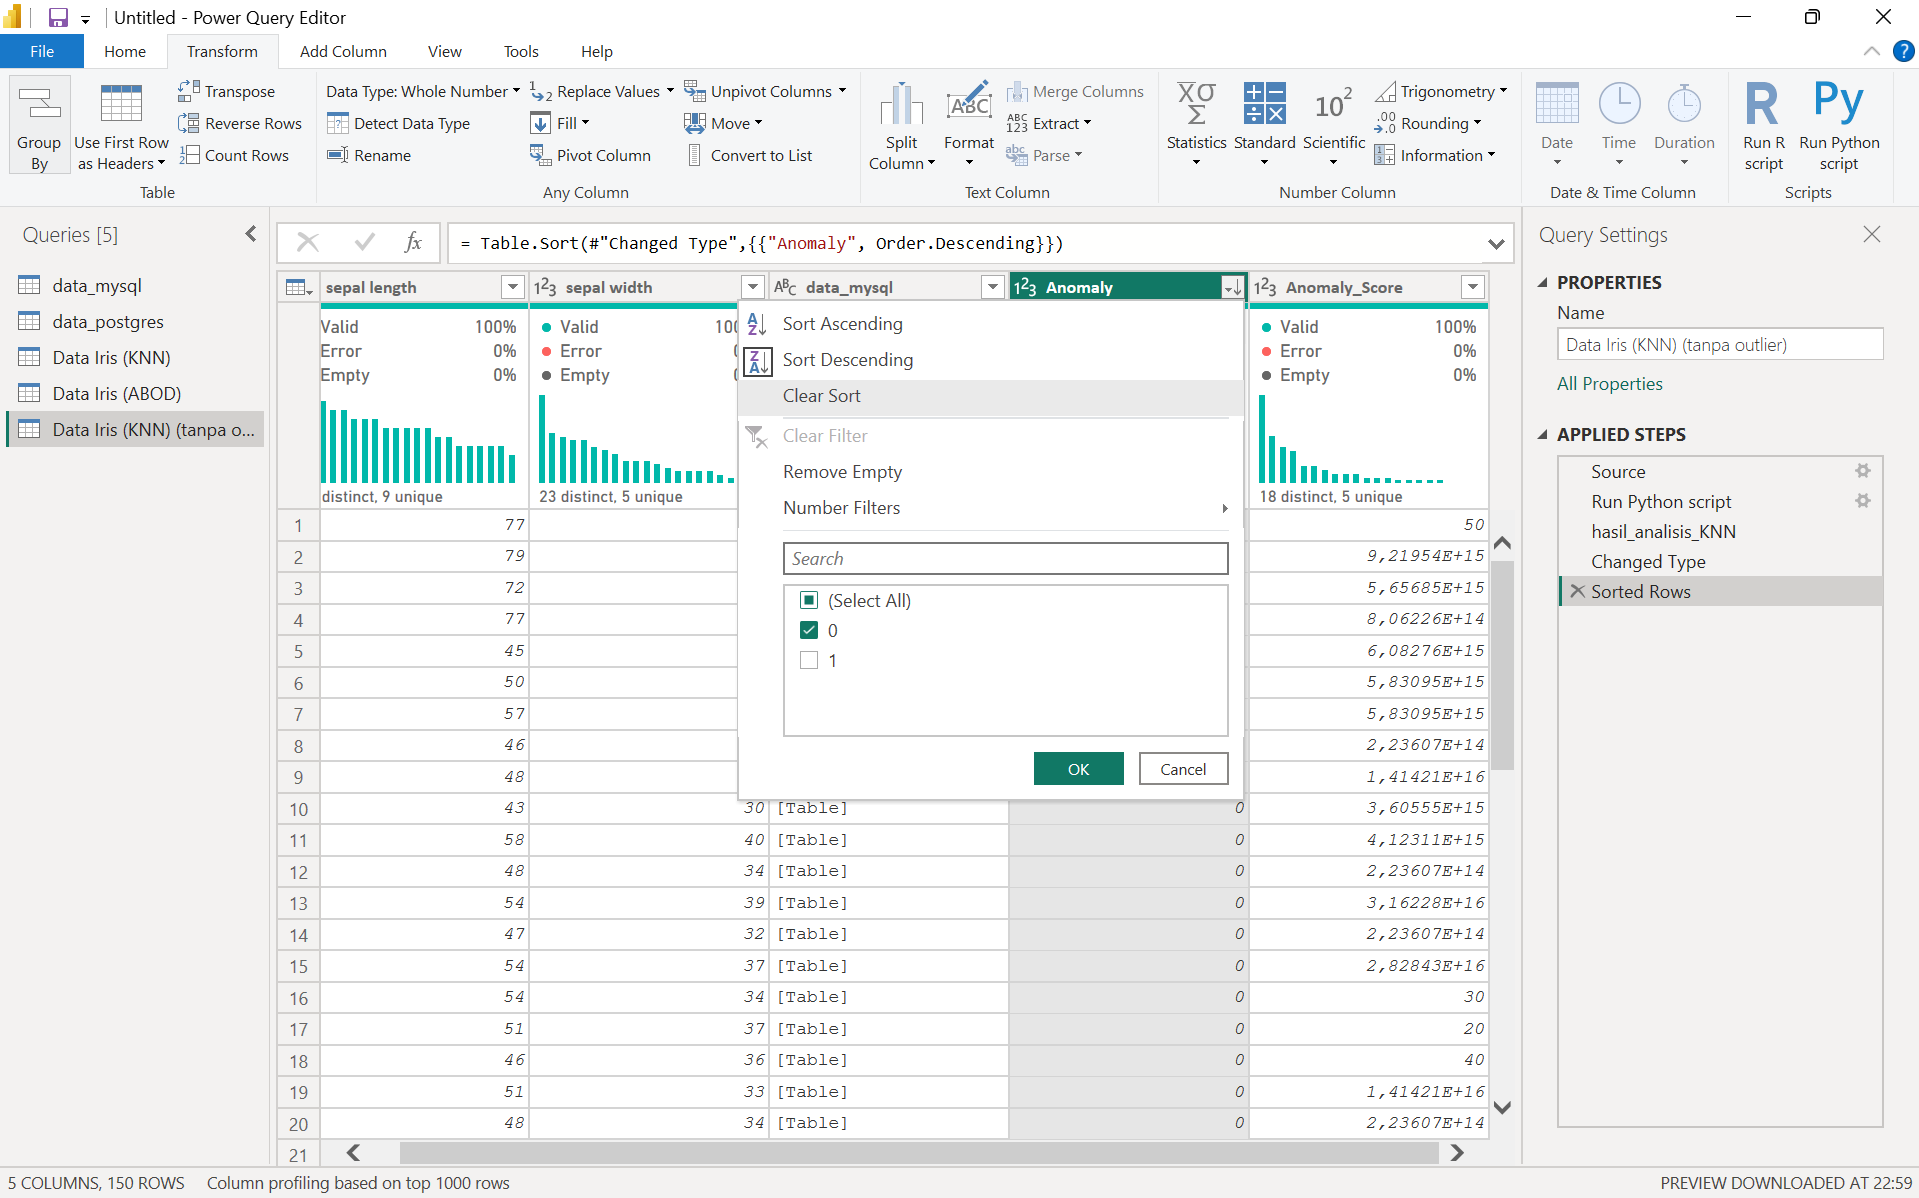

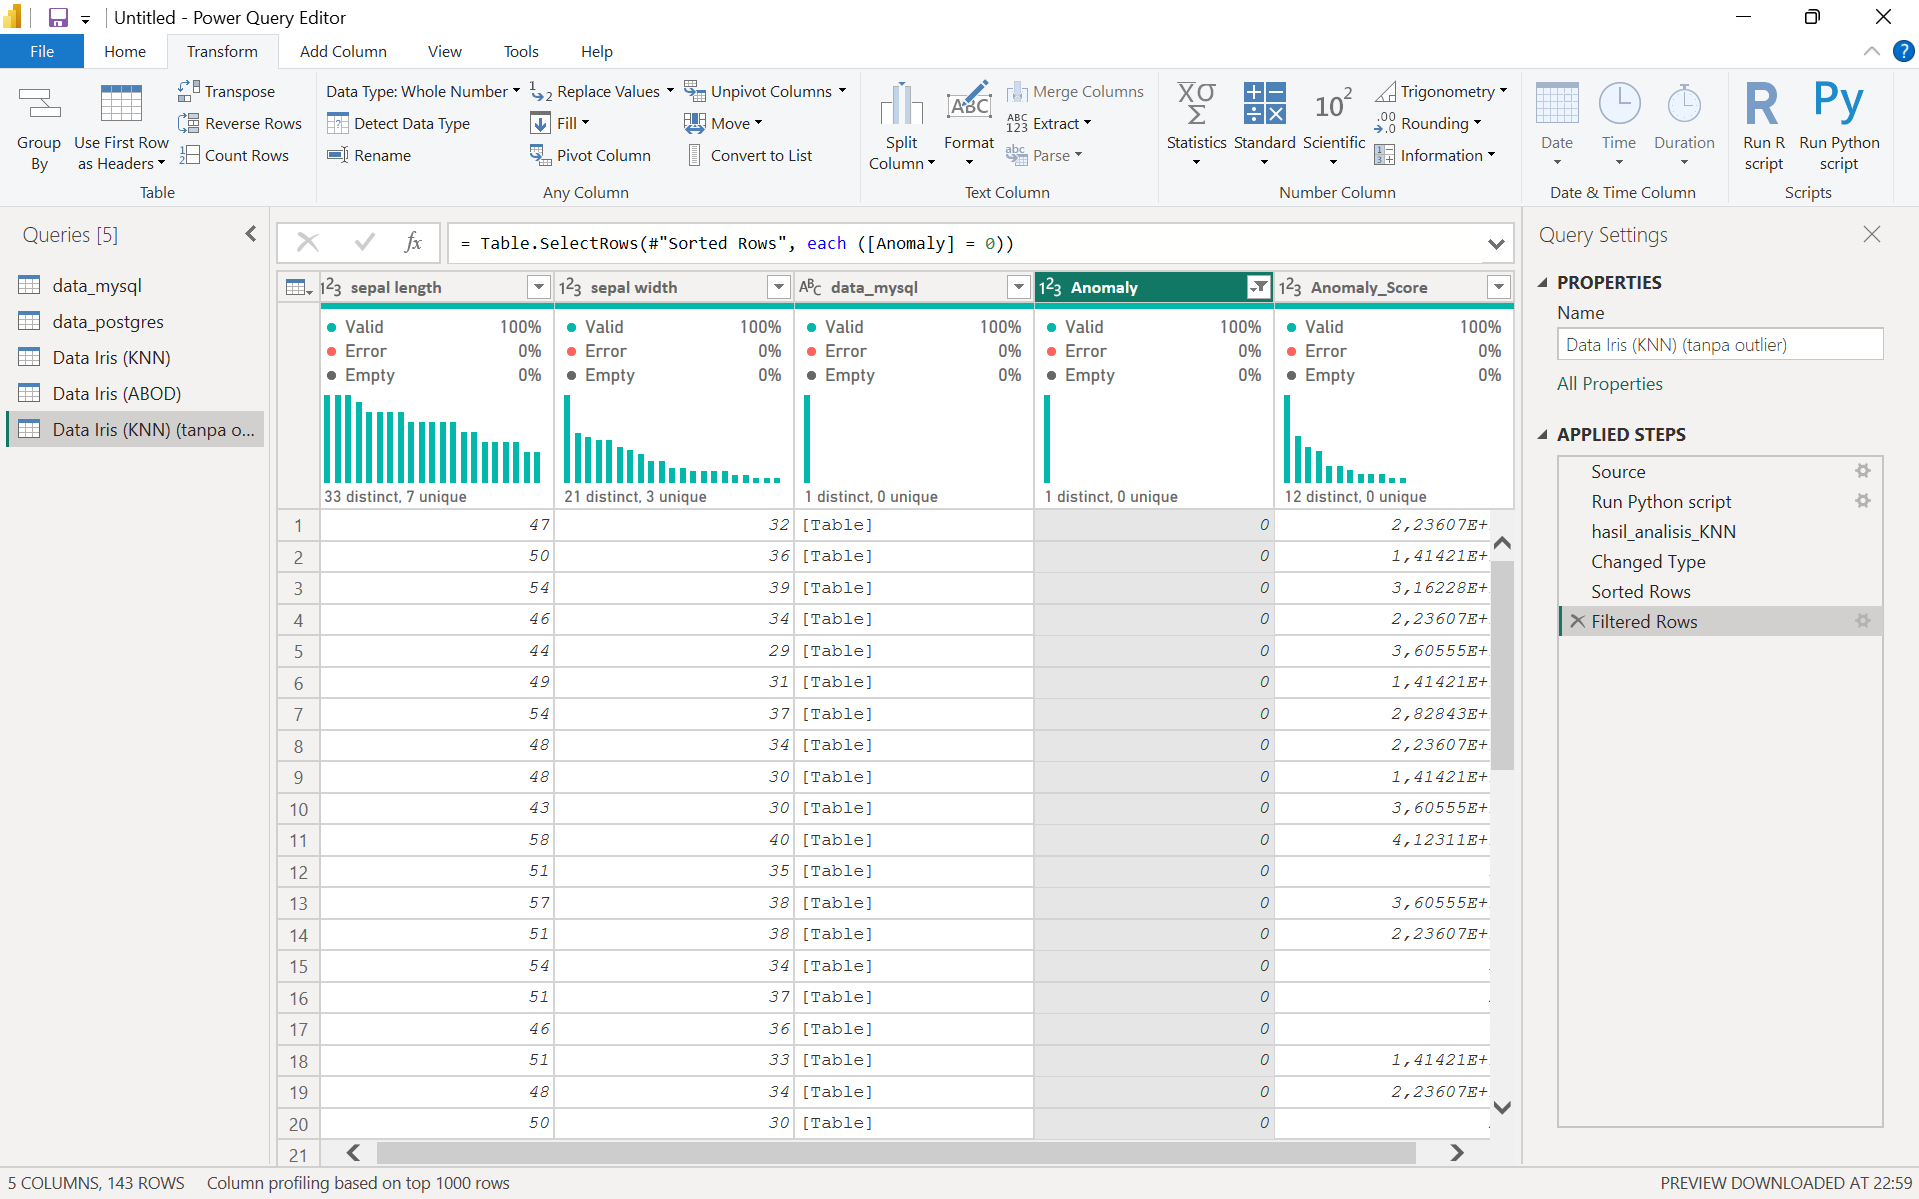

### **Outlier dengan ABOD**


- Masukkan script python dibawah ini untuk Analisis Outlier dengan Pycaret (ABOD)

In [12]:
anomaly_setup = setup(data = data_gabungan, 
                      ignore_features = ['id'], 
                      session_id = 123, 
                      verbose = False)

abod_model = create_model('abod')

# Mengubah nama variabel agar lebih deskriptif
hasil_analisis_ABOD = assign_model(abod_model)


# --- Bagian 2: PENGEMBANGAN - Menampilkan Outlier dan Rangkuman ---

# Filter DataFrame untuk mendapatkan baris yang merupakan outlier (Anomaly == 1)
outliers_abod = hasil_analisis_ABOD[hasil_analisis_ABOD['Anomaly'] == 1]

print("--- Menampilkan Baris Data yang Terdeteksi Outlier (Metode ABOD) ---")

# Cek apakah ada outlier yang ditemukan
if outliers_abod.empty:
  print("✅ Selamat! Tidak ada outlier yang terdeteksi oleh model ABOD.")
else:
  print(f"Ditemukan {len(outliers_abod)} baris data yang merupakan outlier:")
  print(outliers_abod)


# --- Bagian 3: Rangkuman Hasil Analisis ---
print("\n--- Rangkuman Hasil Analisis Outlier (Metode ABOD) ---")

# Menghitung statistik untuk rangkuman
total_data = len(hasil_analisis_ABOD)
jumlah_outlier = len(outliers_abod)
persentase_outlier = (jumlah_outlier / total_data) * 100

# Menampilkan teks rangkuman
print(f"📊 Metode yang digunakan: Angle-Based Outlier Detection (ABOD).")
print(f"📈 Dari total {total_data} data, model ABOD mengidentifikasi {jumlah_outlier} data sebagai outlier.")
print(f"📉 Persentase data outlier dalam dataset ini adalah {persentase_outlier:.2f}%.")
print(f"💡 Kolom 'Anomaly_Score' pada metode ABOD menunjukkan varian sudut. Semakin kecil nilainya (lebih dekat ke nol), semakin besar kemungkinan data tersebut adalah outlier.")

--- Menampilkan Baris Data yang Terdeteksi Outlier (Metode ABOD) ---
Ditemukan 8 baris data yang merupakan outlier:
     sepal length  sepal width  petal length  petal width  Anomaly  \
41            4.5          2.3           1.3          0.3        1   
62            6.0          2.2           4.0          1.0        1   
100           6.3          3.3           6.0          2.5        1   
106           4.9          2.5           4.5          1.7        1   
108           6.7          2.5           5.8          1.8        1   
117           7.7          3.8           6.7          2.2        1   
131           7.9          3.8           6.4          2.0        1   
134           6.1          2.6           5.6          1.4        1   

     Anomaly_Score  
41       -0.088998  
62       -0.289391  
100      -0.364475  
106      -0.050388  
108      -0.084224  
117      -0.129286  
131      -0.137417  
134      -0.309969  

--- Rangkuman Hasil Analisis Outlier (Metode ABOD) ---
📊 Metode

- Menghapus nilai Outlier

In [13]:
print("--- Proses Menghapus Outlier (Metode ABOD) ---")

# 1. Buat DataFrame baru yang hanya berisi data non-outlier (Anomaly == 0)
#    Menggunakan .copy() untuk memastikan ini adalah DataFrame baru yang independen.
data_bersih_abod = hasil_analisis_ABOD[hasil_analisis_ABOD['Anomaly'] == 0].copy()

# 2. Hapus kolom 'Anomaly' dan 'Anomaly_Score' yang sudah tidak relevan
data_bersih_abod.drop(columns=['Anomaly', 'Anomaly_Score'], inplace=True)

print("✅ Proses penghapusan outlier berdasarkan ABOD telah selesai.")

# --- Verifikasi Hasil Penghapusan ---
print("\n--- Verifikasi Hasil ---")

# Hitung jumlah baris sebelum dan sesudah penghapusan
jumlah_data_awal = len(hasil_analisis_ABOD)
jumlah_outlier_dihapus = jumlah_data_awal - len(data_bersih_abod)
jumlah_data_bersih = len(data_bersih_abod)

print(f"Jumlah data sebelum dihapus : {jumlah_data_awal} baris")
print(f"Jumlah outlier dihapus      : {jumlah_outlier_dihapus} baris")
print(f"Jumlah data setelah dihapus : {jumlah_data_bersih} baris")

print("\nLima baris pertama dari data yang sudah bersih (setelah ABOD):")
print(data_bersih_abod.head())

# Simpan hasil data bersih ke CSV
data_bersih_abod.to_csv("data_bersih_abod.csv", index=False, encoding="utf-8")

print("\n✅ File 'data_bersih_abod.csv' berhasil dibuat.")

--- Proses Menghapus Outlier (Metode ABOD) ---
✅ Proses penghapusan outlier berdasarkan ABOD telah selesai.

--- Verifikasi Hasil ---
Jumlah data sebelum dihapus : 150 baris
Jumlah outlier dihapus      : 8 baris
Jumlah data setelah dihapus : 142 baris

Lima baris pertama dari data yang sudah bersih (setelah ABOD):
   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

✅ File 'data_bersih_abod.csv' berhasil dibuat.


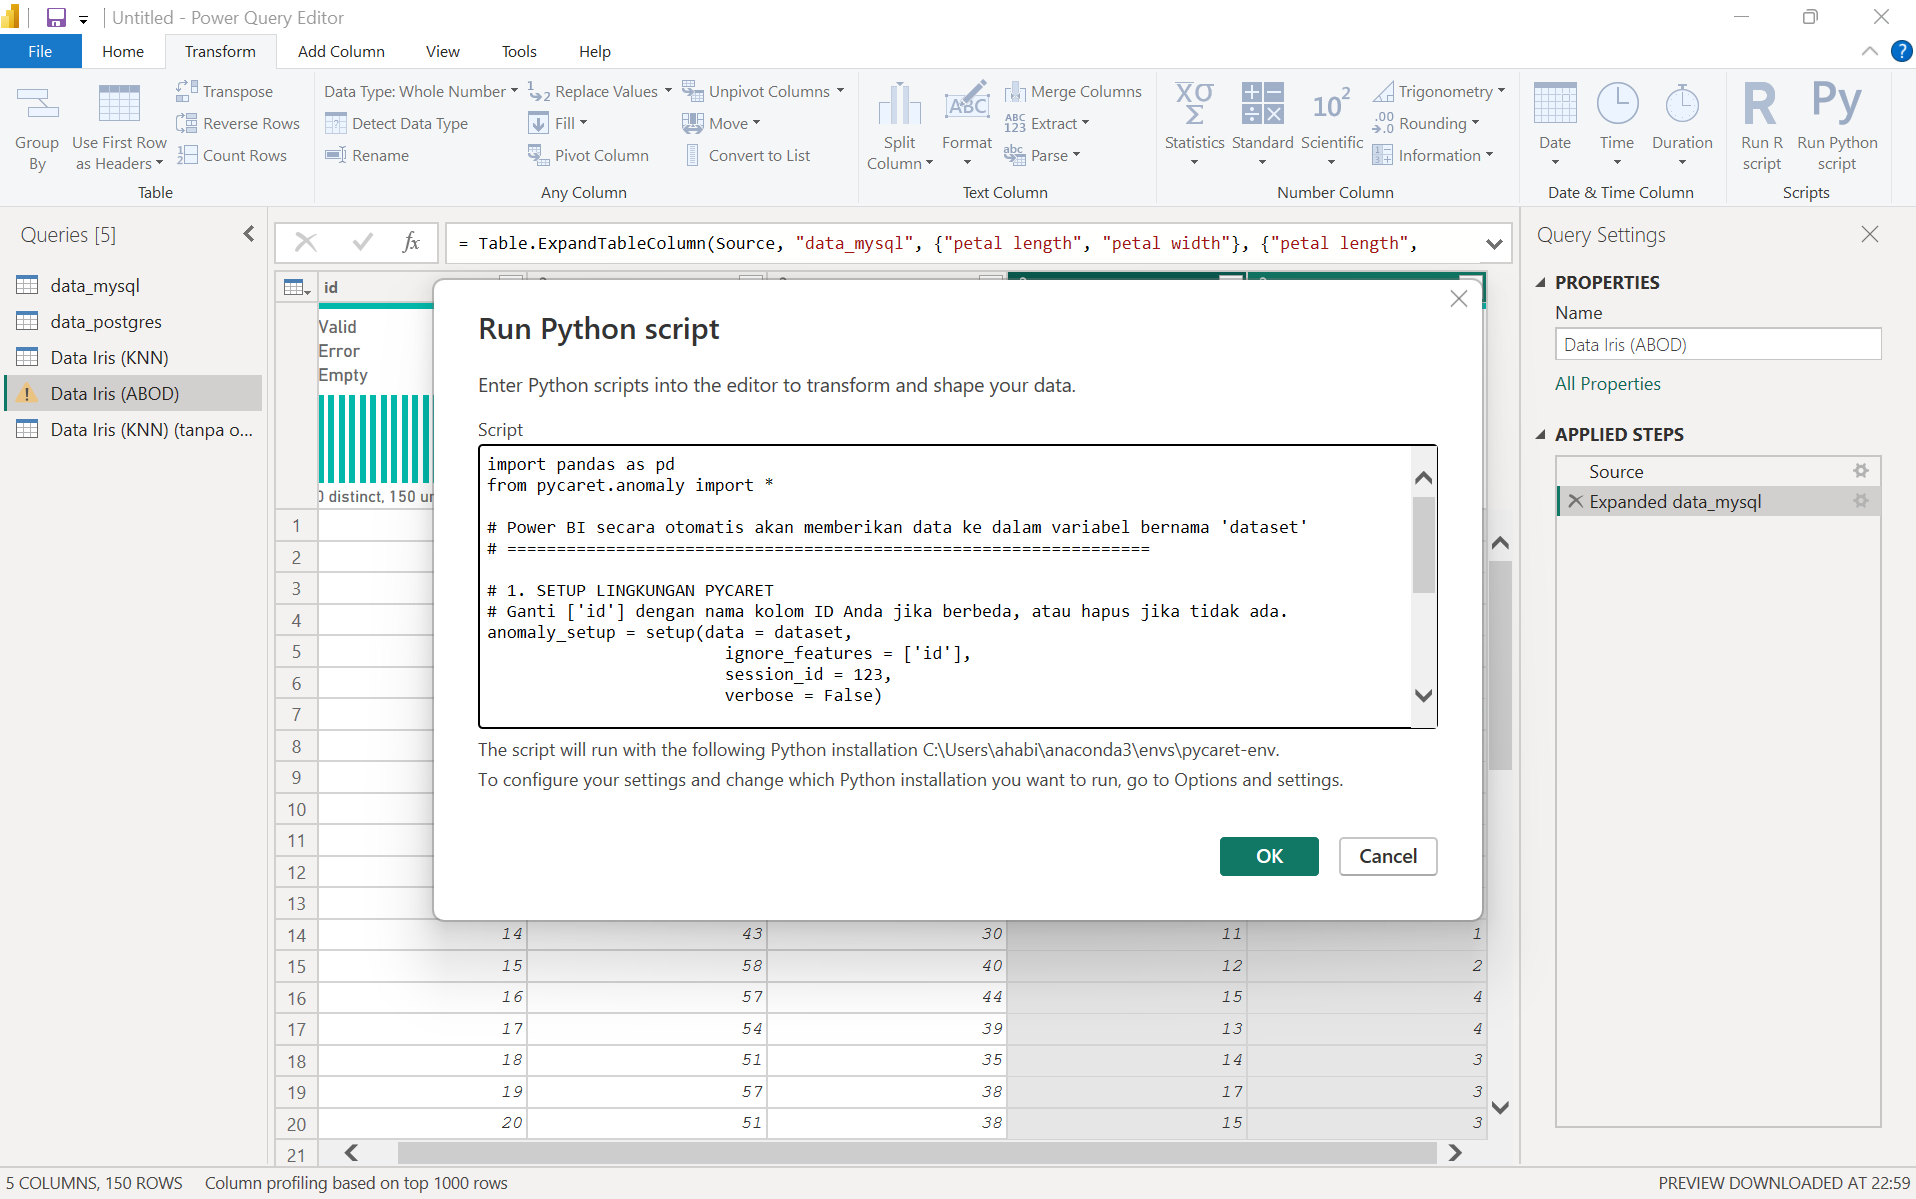

Setelah script berhasil berjalan, Power Query akan menampilkan hasilnya sebagai sebuah objek. Klik pada kata "Table",Hasilnya adalah tabel asli Anda yang kini memiliki dua kolom baru yaitu:

Anomaly: Berisi nilai 1 (jika outlier) atau 0 (jika bukan outlier).
Anomaly_Score: Skor numerik yang menunjukkan seberapa besar kemungkinan sebuah data adalah outlier.

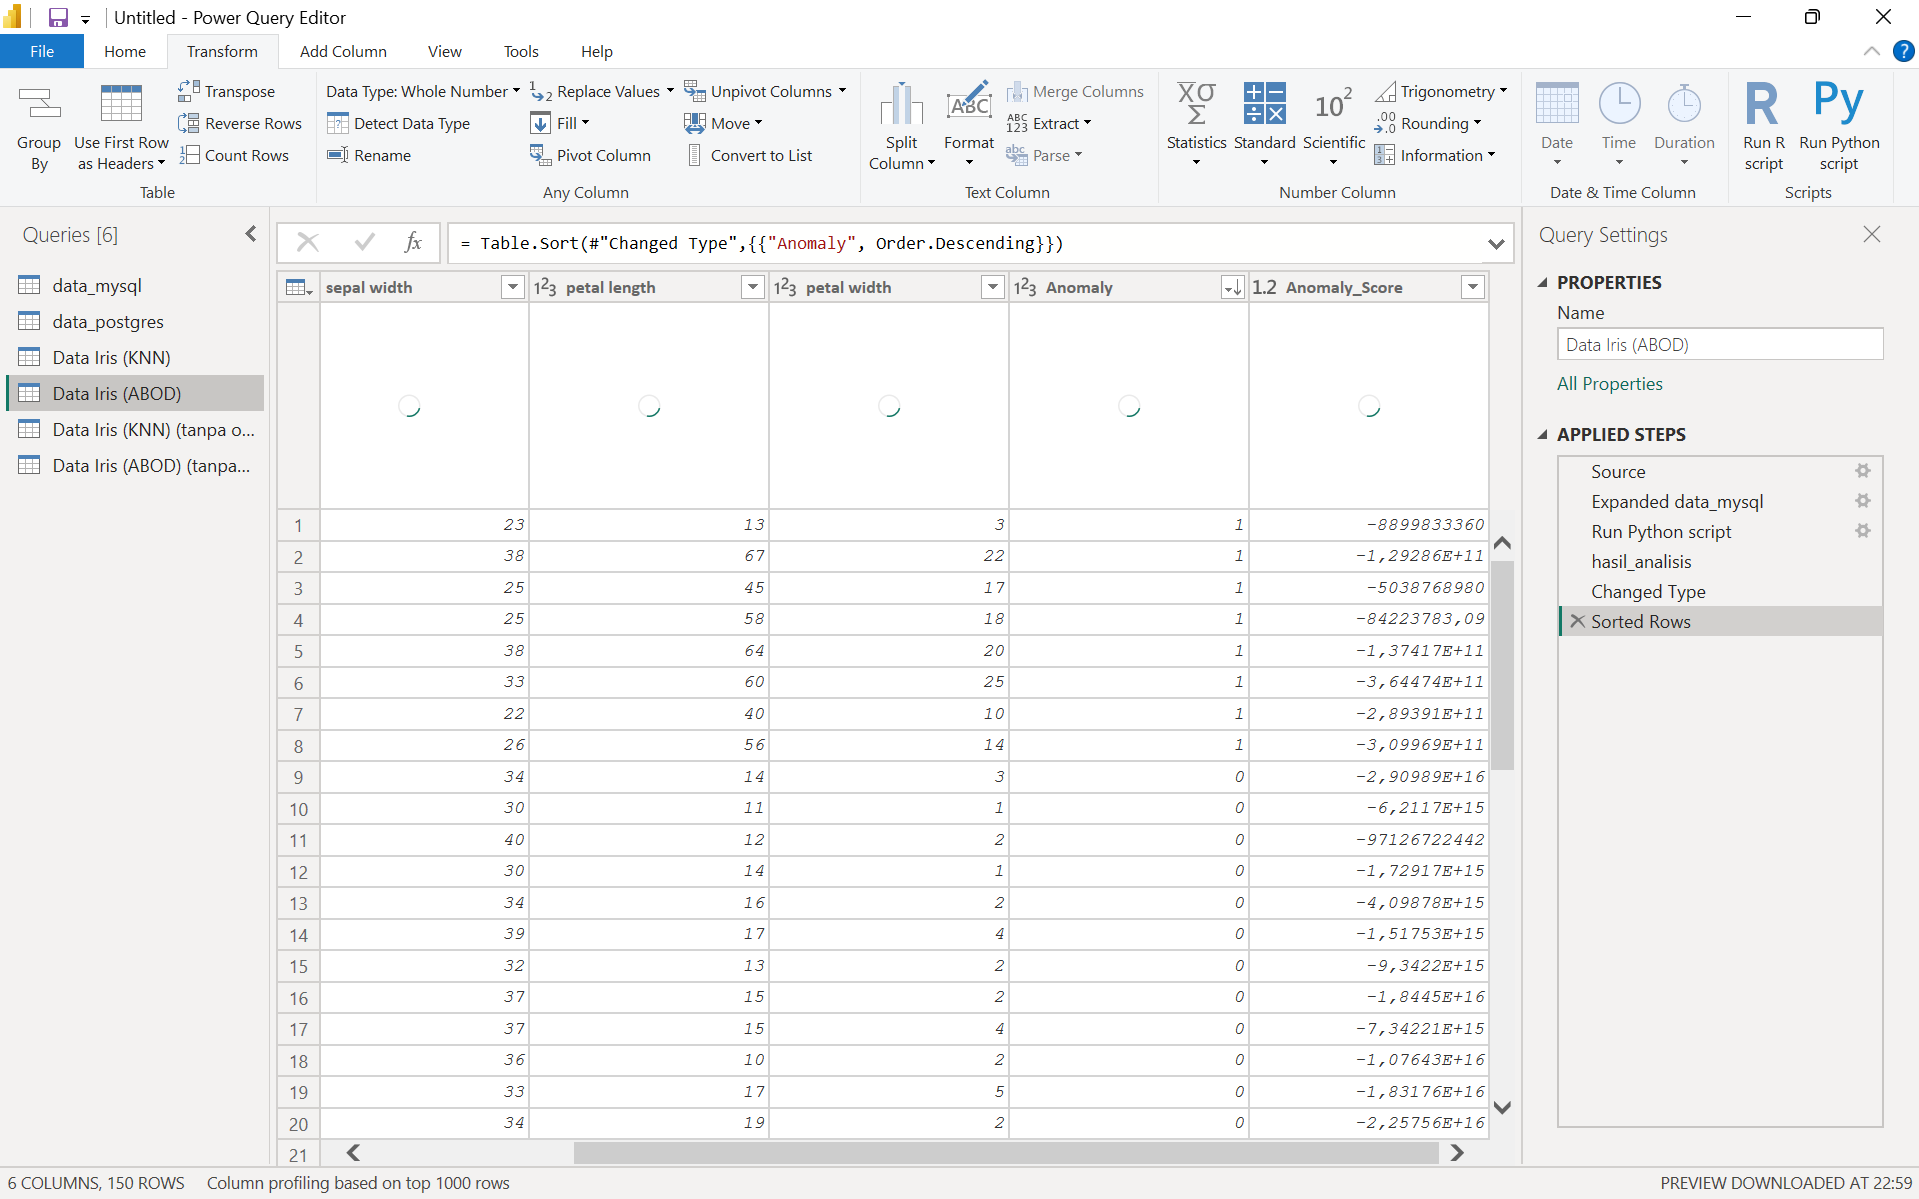

setelah itu hapus nilai outlier dengan cara Di Power Query Editor, filter kolom Anomaly dengan menghapus centang nilai 1 sehingga hanya menampilkan baris bernilai 0 (inlier), lalu klik OK untuk menerapkan perubahan.Setelah proses ini data menjadi lebih bersih dan bisa kita lanjutkan lagi untuk proses selanjutnya yaitu clustering.

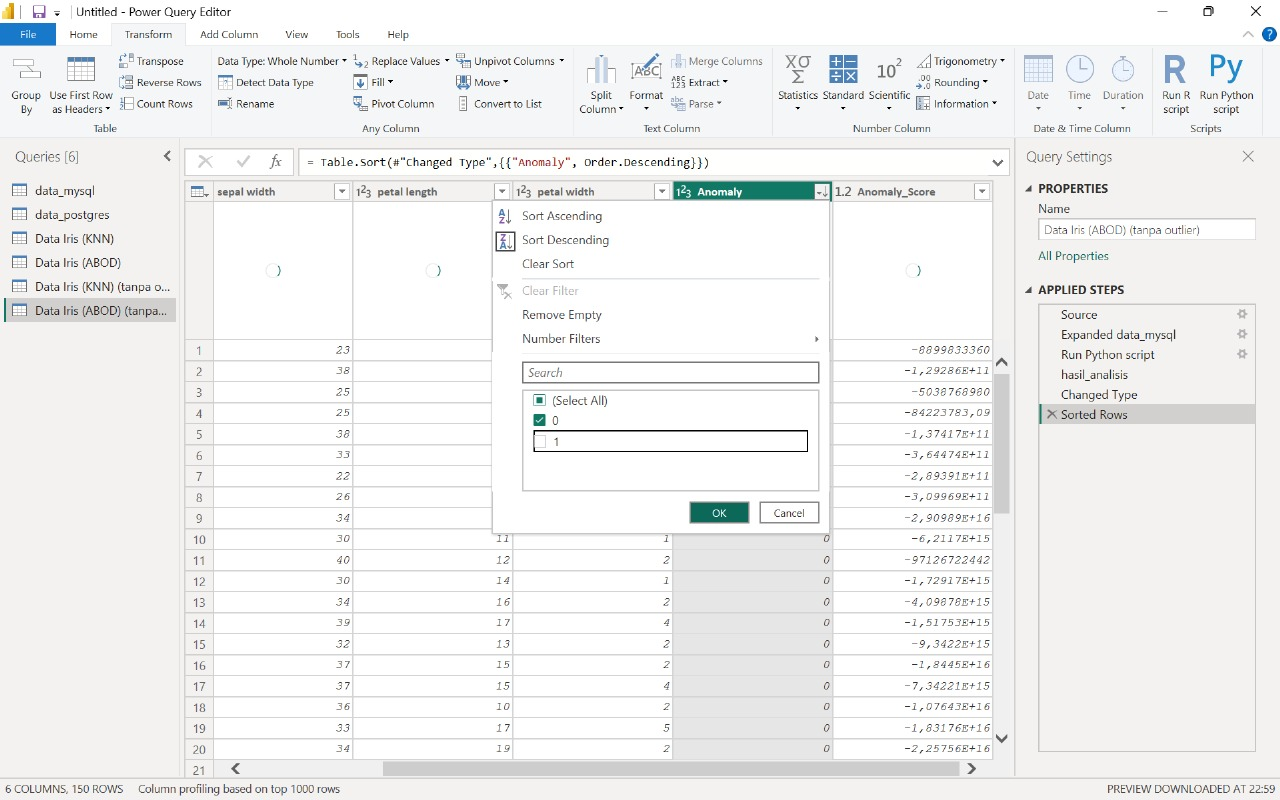
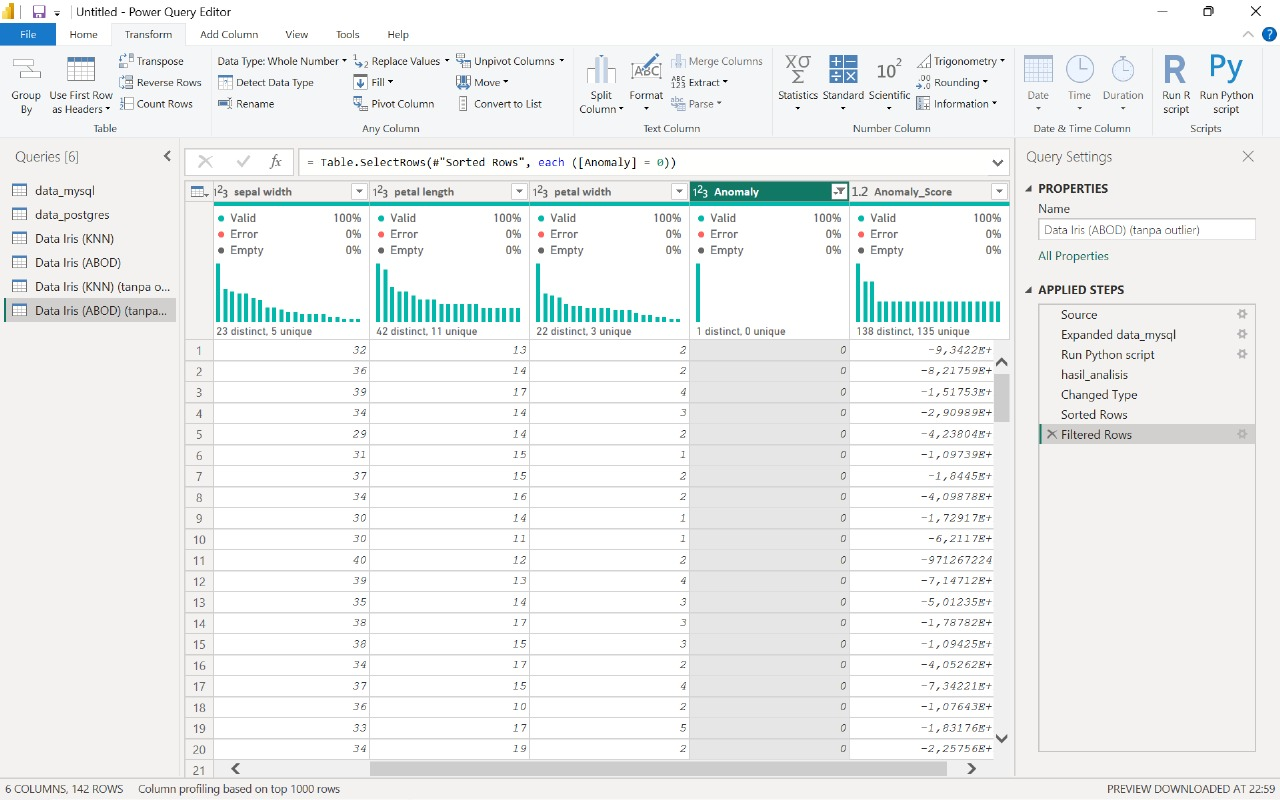

### **Outlier dengan LOF**

In [14]:
# --- Bagian 1: Setup dan Pembuatan Model ---

# Setup lingkungan PyCaret (tidak ada perubahan)
anomaly_setup = setup(data = data_gabungan, 
                      ignore_features = ['id'], 
                      session_id = 123, 
                      verbose = False)

# PERUBAHAN: Menggunakan 'lof' sebagai model
lof_model = create_model('lof')

# Mengubah nama variabel agar sesuai dengan model LOF
hasil_analisis_LOF = assign_model(lof_model)


# --- Bagian 2: Menampilkan Outlier dan Rangkuman ---

# Filter DataFrame untuk mendapatkan baris yang merupakan outlier
outliers_lof = hasil_analisis_LOF[hasil_analisis_LOF['Anomaly'] == 1]

print("--- Menampilkan Baris Data yang Terdeteksi Outlier (Metode LOF) ---")

# Cek apakah ada outlier yang ditemukan
if outliers_lof.empty:
  print("✅ Selamat! Tidak ada outlier yang terdeteksi oleh model LOF.")
else:
  print(f"Ditemukan {len(outliers_lof)} baris data yang merupakan outlier:")
  print(outliers_lof)


# --- Bagian 3: Rangkuman Hasil Analisis ---
print("\n--- Rangkuman Hasil Analisis Outlier (Metode LOF) ---")

# Menghitung statistik untuk rangkuman
total_data = len(hasil_analisis_LOF)
jumlah_outlier = len(outliers_lof)
persentase_outlier = (jumlah_outlier / total_data) * 100

# Menampilkan teks rangkuman
print(f"📊 Metode yang digunakan: Local Outlier Factor (LOF).")
print(f"📈 Dari total {total_data} data, model LOF mengidentifikasi {jumlah_outlier} data sebagai outlier.")
print(f"📉 Persentase data outlier dalam dataset ini adalah {persentase_outlier:.2f}%.")
print(f"💡 Kolom 'Anomaly_Score' pada metode LOF menunjukkan rasio kepadatan. Nilai yang secara signifikan lebih besar dari 1 menunjukkan bahwa titik tersebut berada di area yang jauh lebih renggang daripada tetangganya, sehingga kemungkinan besar adalah outlier.")

--- Menampilkan Baris Data yang Terdeteksi Outlier (Metode LOF) ---
Ditemukan 8 baris data yang merupakan outlier:
     sepal length  sepal width  petal length  petal width  Anomaly  \
14            5.8          4.0           1.2          0.2        1   
15            5.7          4.4           1.5          0.4        1   
41            4.5          2.3           1.3          0.3        1   
98            5.1          2.5           3.0          1.1        1   
117           7.7          3.8           6.7          2.2        1   
118           7.7          2.6           6.9          2.3        1   
122           7.7          2.8           6.7          2.0        1   
131           7.9          3.8           6.4          2.0        1   

     Anomaly_Score  
14        1.463125  
15        1.653626  
41        1.777233  
98        1.511868  
117       1.572990  
118       1.624653  
122       1.491365  
131       1.547288  

--- Rangkuman Hasil Analisis Outlier (Metode LOF) ---
📊 Metode y

- menghapus nilai Outlier

In [15]:
# Diasumsikan DataFrame 'hasil_analisis_LOF' sudah ada dari kode sebelumnya.

print("--- Proses Menghapus Outlier (Metode LOF) ---")

# 1. Buat DataFrame baru hanya dengan data yang bukan outlier (Anomaly == 0)
#    Gunakan .copy() untuk memastikan ini adalah DataFrame baru yang independen.
data_bersih_lof = hasil_analisis_LOF[hasil_analisis_LOF['Anomaly'] == 0].copy()

# 2. Hapus kolom 'Anomaly' dan 'Anomaly_Score' yang sudah tidak diperlukan
data_bersih_lof.drop(columns=['Anomaly', 'Anomaly_Score'], inplace=True)

print("✅ Proses penghapusan outlier berdasarkan LOF telah selesai.")

# --- Verifikasi Hasil Penghapusan ---
print("\n--- Verifikasi Hasil ---")

# Hitung jumlah baris sebelum dan sesudah penghapusan
jumlah_data_awal = len(hasil_analisis_LOF)
jumlah_outlier_dihapus = jumlah_data_awal - len(data_bersih_lof)
jumlah_data_bersih = len(data_bersih_lof)

print(f"Jumlah data sebelum dihapus : {jumlah_data_awal} baris")
print(f"Jumlah outlier dihapus      : {jumlah_outlier_dihapus} baris")
print(f"Jumlah data setelah dihapus : {jumlah_data_bersih} baris")

print("\nLima baris pertama dari data yang sudah bersih (setelah LOF):")
print(data_bersih_lof.head())

# Simpan hasil data bersih ke CSV
data_bersih_lof.to_csv("data_bersih_lof.csv", index=False, encoding="utf-8")

print("\n✅ File 'data_bersih_lof.csv' berhasil dibuat.")

--- Proses Menghapus Outlier (Metode LOF) ---
✅ Proses penghapusan outlier berdasarkan LOF telah selesai.

--- Verifikasi Hasil ---
Jumlah data sebelum dihapus : 150 baris
Jumlah outlier dihapus      : 8 baris
Jumlah data setelah dihapus : 142 baris

Lima baris pertama dari data yang sudah bersih (setelah LOF):
   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

✅ File 'data_bersih_lof.csv' berhasil dibuat.


### **Clustering K-Means**


### **-  Menggunakan library PyCaret**

In [16]:
import pandas as pd
from pycaret.clustering import *

# Asumsikan 'data_gabungan' sudah siap
cluster_setup = setup(data = data_gabungan,
                      ignore_features = ['id'],
                      session_id = 123,
                      verbose = False)

kmeans_model = create_model('kmeans', num_clusters = 3)

hasil_clustering = assign_model(kmeans_model)

hasil_clustering['Cluster'] = hasil_clustering['Cluster'].str.replace('Cluster ', '').astype(int) + 1
hasil_clustering['Cluster'] = 'Cluster ' + hasil_clustering['Cluster'].astype(str)


# --- Rangkuman dan Analisis (sekarang akan menggunakan label 1, 2, 3) ---
print("--- Menampilkan Hasil Clustering (setelah label diubah) ---")
print(hasil_clustering.head())

print("\n--- Rangkuman Hasil Clustering K-Means ---")

# Menghitung jumlah anggota di setiap cluster
jumlah_anggota_cluster = hasil_clustering['Cluster'].value_counts().sort_index()

print(f"✅ Model K-Means berhasil membagi data menjadi {len(jumlah_anggota_cluster)} cluster.")
print("✅ Berikut adalah distribusi data di setiap cluster:")

for cluster_name, count in jumlah_anggota_cluster.items():
    print(f"   - {cluster_name}: {count} anggota")

print("\n✅ Analisis Karakteristik Rata-rata per Cluster:")
karakteristik_cluster = hasil_clustering.groupby('Cluster').mean()
print(karakteristik_cluster)

# Simpan hasil clustering lengkap ke CSV
hasil_clustering.to_csv("hasil_clustering_kmeans.csv", index=False, encoding="utf-8")

print("\n✅ File 'hasil_clustering_kmeans.csv' berhasil dibuat.")

# Simpan juga rangkuman karakteristik rata-rata tiap cluster ke CSV (opsional)
karakteristik_cluster.to_csv("rangkuman_karakteristik_cluster.csv", encoding="utf-8")

print("✅ File 'rangkuman_karakteristik_cluster.csv' berhasil dibuat.")

--- Menampilkan Hasil Clustering (setelah label diubah) ---
   sepal length  sepal width  petal length  petal width    Cluster
0           5.1          3.5           1.4          0.2  Cluster 2
1           4.9          3.0           1.4          0.2  Cluster 2
2           4.7          3.2           1.3          0.2  Cluster 2
3           4.6          3.1           1.5          0.2  Cluster 2
4           5.0          3.6           1.4          0.2  Cluster 2

--- Rangkuman Hasil Clustering K-Means ---
✅ Model K-Means berhasil membagi data menjadi 3 cluster.
✅ Berikut adalah distribusi data di setiap cluster:
   - Cluster 1: 38 anggota
   - Cluster 2: 50 anggota
   - Cluster 3: 62 anggota

✅ Analisis Karakteristik Rata-rata per Cluster:
           sepal length  sepal width  petal length  petal width
Cluster                                                        
Cluster 1      6.850000     3.073684      5.742105     2.071053
Cluster 2      5.006000     3.418000      1.464000     0.244000

### **File data hasil analysis outlier dan clustering**
a. Analysis Outlier
- KNN :https://drive.google.com/file/d/1mibBvptGey3MfiSh9VGtfHzeGICdzwLU/view?usp=drive_link
- ABOD :https://drive.google.com/file/d/1k5L18G0f-1_4-u_kMXRNcReTxbNMfUAV/view?usp=drive_link
- LOF :https://drive.google.com/file/d/1hy_l-tht8x4u7uhwhIDr7KwPR7VVpp79/view?usp=drive_link

b. Clustering
- K-Means :https://drive.google.com/file/d/1YbGzp874zISRVP6nl23LHZEjv958Cj7E/view?usp=drive_link
- rangkuman hasil cluster : https://drive.google.com/file/d/1PtAbcKYJ0e2dn75hNTU4i0mFpgalU5GS/view?usp=drive_link
